In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

import time
import wandb

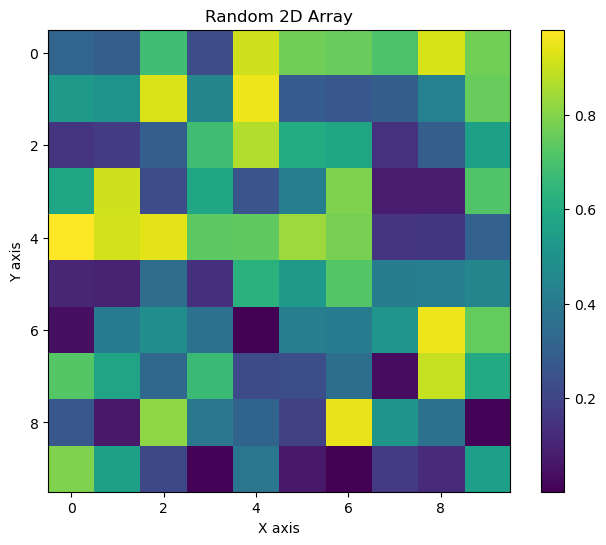

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '5', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'CIFAR10' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} fc_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [512]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [4]},
        "IMAGE_SIZE": {"values": [32]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: d5ebsqp9
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/d5ebsqp9


wandb: Agent Starting Run: xf1gh4k9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.238710091146486
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.062, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.44%
Test loss: 1.977, Val Accuracy: 32.46%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.936, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 33.90%
Test loss: 1.903, Val Accuracy: 35.11%


epoch,▁▃▆█
iter_accuracy,▂▁▂▄▅▅▆▅▆▆▅▆▆▇▅▆▇▆▇▇▇▇▆▇▆█▇▇▇███▆▇██▇▆██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,37.20238
tr_accuracy,33.9
val_accuracy,35.11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: enpk69iw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9658853241952303
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.09%
Test loss: 1.894, Val Accuracy: 33.41%
Epoch 2
Train Accuracy: 31.38%
Test loss: 1.872, Val Accuracy: 34.21%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.871, Val Accuracy: 34.68%
Epoch 4
Train Accuracy: 32.81%
Test loss: 1.847, Val Accuracy: 35.49%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▅▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▆███▇▆▆▆▇█▇▇▇▆████
tr_accuracy,▁▆██
val_accuracy,▁▄▅█
epoch,3
iter_accuracy,35.71429
tr_accuracy,32.806
val_accuracy,35.49


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hl8yhre7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.773358707554443
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.050, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 29.91%
Test loss: 1.968, Val Accuracy: 31.66%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.925, Val Accuracy: 33.09%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.896, Val Accuracy: 34.59%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▅▄▄▅▅▅▆▅▅▆▆▆▅▆▆▆▆▆▇▇▆▆▆▆▇▆▇▇▇▆▇▆█▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,34.22619
tr_accuracy,33.996
val_accuracy,34.59


wandb: Agent Starting Run: 9h0hmlxe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.987140633650972
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.901, Val Accuracy: 33.65%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.878, Val Accuracy: 35.03%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.857, Val Accuracy: 34.82%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.852, Val Accuracy: 35.95%


epoch,▁▃▆█
iter_accuracy,▁▆▄▅▆▆▇▆▇▇▇▆▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇█▇▇█▇██▇▇▇██▇
tr_accuracy,▁▆██
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.018
val_accuracy,35.95


wandb: Agent Starting Run: vcxydn3n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7768088550459802
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.34%
Test loss: 2.061, Val Accuracy: 25.48%
Epoch 2
Train Accuracy: 25.76%
Test loss: 2.001, Val Accuracy: 30.24%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.968, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.62%
Test loss: 1.945, Val Accuracy: 33.51%


epoch,▁▃▆█
iter_accuracy,▁▂▁▃▃▃▄▄▅▅▅▅▅▆▄▅▆▆▅▅▇▇▅▇▇▇▅▇▆▆▇▇▇▆█▇▇▇▇▇
tr_accuracy,▁▅▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,29.62
val_accuracy,33.51


wandb: Agent Starting Run: lalc2al5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.415850887248157
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.66%
Test loss: 2.047, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.966, Val Accuracy: 31.56%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.919, Val Accuracy: 33.34%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.890, Val Accuracy: 35.23%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▃▄▅▄▅▅▇▅▄▅▆▆▅▅▇▇▇▆▅▆▆▇▇▇▇▇▆▆▇▆▇▇▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.238
val_accuracy,35.23


wandb: Agent Starting Run: eae5vqgt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3444678158977923
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.026, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.949, Val Accuracy: 32.54%
Epoch 3
Train Accuracy: 33.45%
Test loss: 1.909, Val Accuracy: 34.21%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.884, Val Accuracy: 35.74%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▄▄▄▅▆▆▆▆▆▇▆▆▆▇▆▇▇▇▇▇▆▆▇▇▇▇█▆▇█▇█▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.484
val_accuracy,35.74


wandb: Agent Starting Run: ptdq3jtd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.444684705518384
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.19%
Test loss: 2.004, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 27.50%
Test loss: 1.954, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 29.25%
Test loss: 1.923, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.911, Val Accuracy: 33.84%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▄▆▅▆▆▆▆▇▆▆▅▆▇▇█▇▇▇▇▇▇▇█▇█▇▆▆▇█▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.7619
tr_accuracy,30.046
val_accuracy,33.84


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t1db12pk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.449647385088557
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.045, Val Accuracy: 28.37%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.960, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.918, Val Accuracy: 34.22%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.888, Val Accuracy: 34.64%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▄▅▅▅▆▆▆▅▆▆▆▇▆▇▆▆▆▇▇▆▇▇▆▇▇▇▇▇▆█▇▇▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,31.54762
tr_accuracy,34.476
val_accuracy,34.64


wandb: Agent Starting Run: t4gc4j5x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.987905713387438
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.047, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.960, Val Accuracy: 32.82%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.916, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.891, Val Accuracy: 35.19%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▅▆▅▅▆▆▆▇▇▇▆▇▇▅▇▆▆▇▆▆▇█▆▆▇▇▇█▇▇▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.118
val_accuracy,35.19


wandb: Agent Starting Run: egm3p37v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4410993273649955
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.28%
Test loss: 1.893, Val Accuracy: 33.20%
Epoch 2
Train Accuracy: 31.78%
Test loss: 1.877, Val Accuracy: 34.59%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.861, Val Accuracy: 34.98%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.852, Val Accuracy: 35.79%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▇▆▇▆▇▆█▆█▆▇▅▇▇▇▆▇▇▇█▇▆█▆▇▇█▇▇▇▇█▇▆
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.25
tr_accuracy,33.122
val_accuracy,35.79


wandb: Agent Starting Run: 9n95xc2m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.096420882145231
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 2.002, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.953, Val Accuracy: 31.18%
Epoch 3
Train Accuracy: 28.52%
Test loss: 1.934, Val Accuracy: 32.47%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.925, Val Accuracy: 32.83%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▅▅▆▆▇▆▇▆▆▅█▆▆▆▅▆▇▇▇▇▆▆▇▇█▆▆▇▇▆▆▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,27.67857
tr_accuracy,29.108
val_accuracy,32.83


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ixe58uav with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.436553706437988
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.888, Val Accuracy: 33.29%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.875, Val Accuracy: 34.38%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.858, Val Accuracy: 35.23%
Epoch 4
Train Accuracy: 32.66%
Test loss: 1.847, Val Accuracy: 35.66%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▆▇▇▆█▆▇▆▅▇▅▆▆▅▇▆▇▇▇▇▆▆▆█▆▆▆▆▇█▇▆▇▇▇
tr_accuracy,▁▇██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,32.656
val_accuracy,35.66


wandb: Agent Starting Run: htmmz1aq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.428326077161857
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.026, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.955, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.912, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.887, Val Accuracy: 34.71%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇▆▇▇█▆██▇▆▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.368
val_accuracy,34.71


wandb: Agent Starting Run: iv1oboi9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.63533041191064
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.32%
Test loss: 1.900, Val Accuracy: 34.06%
Epoch 2
Train Accuracy: 31.99%
Test loss: 1.872, Val Accuracy: 34.44%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.857, Val Accuracy: 35.26%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.858, Val Accuracy: 35.89%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▆▅▅▆▆▆▇▇▆▆▆▇▇▇▇▇▆█▇▇▆█▅▆▇▇█▆▇█▆█▆▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁▂▆█
epoch,3
iter_accuracy,34.82143
tr_accuracy,33.046
val_accuracy,35.89


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jmcnla0p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.854905907811379
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.043, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 30.84%
Test loss: 1.960, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.914, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.888, Val Accuracy: 35.21%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▃▃▄▄▅▅▆▅▅▅▅▅▅▆▇▅▅▅▆▅▆▅▇▆▅▇▆▇▅▆██▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.526
val_accuracy,35.21


wandb: Agent Starting Run: tabakclc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.943507463190486
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.030, Val Accuracy: 28.68%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.951, Val Accuracy: 32.05%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.911, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.886, Val Accuracy: 34.70%


epoch,▁▃▆█
iter_accuracy,▂▁▃▄▄▅▅▆▆▅▆▆▆▆▆▇▆▆▇▇▆▆▆▆▇▆▇▇▇▇▇▇█▆▇█▇▆▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.32
val_accuracy,34.7


wandb: Agent Starting Run: 920c04vf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.338918186672965
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.897, Val Accuracy: 32.67%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.886, Val Accuracy: 33.51%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.865, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.861, Val Accuracy: 35.23%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▆▆▆▆▆▆▇▇▇▆▆▇▇█▆▆▇▇▇▆▇█▇▆▆▇▇▇▇█▆▇▇▆
tr_accuracy,▁▆██
val_accuracy,▁▃█▇
epoch,3
iter_accuracy,28.57143
tr_accuracy,33.076
val_accuracy,35.23


wandb: Agent Starting Run: fcyt5mwz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.516482120550997
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.030, Val Accuracy: 29.29%
Epoch 2
Train Accuracy: 31.09%
Test loss: 1.951, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.915, Val Accuracy: 32.98%
Epoch 4
Train Accuracy: 34.61%
Test loss: 1.886, Val Accuracy: 34.69%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▆▅▇▅▅▆▆▆▇▇▆█▇▇▆▆▆▇▇▇▆▇▇▇▇▇█▇██▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.608
val_accuracy,34.69


wandb: Agent Starting Run: u2zzgwcj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.100379306321861
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.59%
Test loss: 2.128, Val Accuracy: 26.18%
Epoch 2
Train Accuracy: 27.65%
Test loss: 2.045, Val Accuracy: 30.30%
Epoch 3
Train Accuracy: 30.29%
Test loss: 2.002, Val Accuracy: 29.70%
Epoch 4
Train Accuracy: 31.44%
Test loss: 1.964, Val Accuracy: 32.71%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▃▄▄▆▆▅▆▇▅▆▇▆▆▆█▇▇▆▇█▇█▇▇▇▇▇█▇█▇▆▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,31.25
tr_accuracy,31.444
val_accuracy,32.71


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lr8e26at with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0681874612502447
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.887, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.856, Val Accuracy: 35.42%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.853, Val Accuracy: 35.60%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.848, Val Accuracy: 35.01%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▅▄▆▆▅▆▇▆█▇▇▆▇▆▇▇▇▇▇▇▇▆▇▇▆█▇▇▇▆▇▇▆▇██
tr_accuracy,▁▇▇█
val_accuracy,▁▇█▅
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.892
val_accuracy,35.01


wandb: Agent Starting Run: 19ardut1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.865627320313179
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.004, Val Accuracy: 29.77%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.955, Val Accuracy: 32.06%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.936, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.31%
Test loss: 1.923, Val Accuracy: 32.96%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▅▅▅▆▆▇▆▆▇▆▆▆▆▆▆▆▇▇▆▆▇▆▇▇▇█▆▇▆▆▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,29.16667
tr_accuracy,29.312
val_accuracy,32.96


wandb: Agent Starting Run: t5glo5dn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.071560464634334
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.52%
Test loss: 1.905, Val Accuracy: 33.04%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.884, Val Accuracy: 34.22%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.857, Val Accuracy: 34.88%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.851, Val Accuracy: 35.32%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▆▆▅▇▅▅▆▆▇▆▇▆█▇▇█▇▆█▇█▇█▇▇▇▇▆▇▇█▇▇▆▇
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,32.878
val_accuracy,35.32


wandb: Agent Starting Run: bxl9hb9u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.628205933285855
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.91%
Test loss: 1.902, Val Accuracy: 33.04%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.868, Val Accuracy: 34.10%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.856, Val Accuracy: 34.87%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.855, Val Accuracy: 35.27%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▆▇▆▆▅▆▄▆▇▇▆▅▇██▇▅▇▇▆▇▇█▆██▇▇█▇▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.11
val_accuracy,35.27


wandb: Agent Starting Run: uqy5j25u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.365017899579948
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.66%
Test loss: 2.047, Val Accuracy: 27.69%
Epoch 2
Train Accuracy: 30.46%
Test loss: 1.964, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.922, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.896, Val Accuracy: 33.92%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▅▆▄▆▅▆▆▆▆▆▇▆▇▇█▇▇▇▇▇███▇▆█▇▆▇▇▆███
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.056
val_accuracy,33.92


wandb: Agent Starting Run: cditp9m9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.529560561582969
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.001, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 27.11%
Test loss: 1.959, Val Accuracy: 31.08%
Epoch 3
Train Accuracy: 28.37%
Test loss: 1.942, Val Accuracy: 31.98%
Epoch 4
Train Accuracy: 29.50%
Test loss: 1.932, Val Accuracy: 32.52%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▆▅▅▅▇▆▆▇▇▆▆▇▇▆▆▅▆▆▆▇▆▇▆▇▇█▇▆▆▇▆▇▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,29.504
val_accuracy,32.52


wandb: Agent Starting Run: kuny67i5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.736258579096374
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.032, Val Accuracy: 28.32%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.955, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.913, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.889, Val Accuracy: 34.46%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▄▅▅▆▆▆▆▅▅▆▆▅▆▆▇▇▇▆▆▇▇▆▇▇▆█▇▆▇█▆▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,33.984
val_accuracy,34.46


wandb: Agent Starting Run: qkt0r7h9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.443028252244763
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.047, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.969, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.920, Val Accuracy: 34.23%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.892, Val Accuracy: 34.68%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇█▇▇▇██▇▇▇▇██▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.364
val_accuracy,34.68


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xc0r751p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.213966539834419
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.059, Val Accuracy: 28.19%
Epoch 2
Train Accuracy: 29.85%
Test loss: 1.981, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 32.20%
Test loss: 1.935, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 33.58%
Test loss: 1.906, Val Accuracy: 33.89%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▅▄▅▅▆▆▆▅▆▅▆▆▇█▆▆▆▆▇▇▆▇▆▆▇▇▆▇▇█▆█▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.578
val_accuracy,33.89


wandb: Agent Starting Run: uzdcidse with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.136747843483853
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.21%
Test loss: 2.028, Val Accuracy: 29.35%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.952, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.914, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 34.33%
Test loss: 1.888, Val Accuracy: 34.31%


epoch,▁▃▆█
iter_accuracy,▁▁▄▅▄▄▆▆▆▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▇██▇▇▇▇▇██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.332
val_accuracy,34.31


wandb: Agent Starting Run: 29qpgm3w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6559356603956035
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.12%
Test loss: 1.902, Val Accuracy: 33.11%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.864, Val Accuracy: 35.35%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.863, Val Accuracy: 34.60%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.859, Val Accuracy: 35.56%


epoch,▁▃▆█
iter_accuracy,▁▄▄▄▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▆▇▆▇▇▇▆▇▆▇▆▇█
tr_accuracy,▁▇▇█
val_accuracy,▁▇▅█
epoch,3
iter_accuracy,37.5
tr_accuracy,32.856
val_accuracy,35.56


wandb: Agent Starting Run: fwquv1k1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.753641412775681
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.055, Val Accuracy: 26.60%
Epoch 2
Train Accuracy: 29.59%
Test loss: 1.970, Val Accuracy: 32.45%
Epoch 3
Train Accuracy: 32.37%
Test loss: 1.926, Val Accuracy: 33.46%
Epoch 4
Train Accuracy: 33.71%
Test loss: 1.897, Val Accuracy: 34.99%


epoch,▁▃▆█
iter_accuracy,▁▃▂▄▃▆▅▆▅▆▅▆▆▇▆▆▆▆▇▇▇▆▇▆▇▇▇▇█▇▇▇▇█▇▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,33.71
val_accuracy,34.99


wandb: Agent Starting Run: t1d971n7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.553736944248636
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.003, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 27.78%
Test loss: 1.946, Val Accuracy: 31.99%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.923, Val Accuracy: 33.18%
Epoch 4
Train Accuracy: 29.69%
Test loss: 1.909, Val Accuracy: 33.72%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▆▅▅▆▅▆▆▆▇▇▇▆▅▇▇▅▇▆▆▆▆▆▇▆▆▇▇▇█▇▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,29.69
val_accuracy,33.72


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hubm1qlz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.648508986018
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.050, Val Accuracy: 28.76%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.964, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.921, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.896, Val Accuracy: 33.72%


epoch,▁▃▆█
iter_accuracy,▁▂▂▂▃▃▅▅▅▆▆▅▅▆▆▆▇▆▆▇▆▇▇▆▆▆▆█▇▇▇█▇▇▇██▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,37.5
tr_accuracy,34.112
val_accuracy,33.72


wandb: Agent Starting Run: kwqydlh7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.533345758266733
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.043, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 30.22%
Test loss: 1.965, Val Accuracy: 31.64%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.922, Val Accuracy: 34.30%
Epoch 4
Train Accuracy: 33.81%
Test loss: 1.891, Val Accuracy: 35.26%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▆▆▅▆▆▇▆▆▆▆▆▆▆▇▇▇▇▇▇▆▆▅▇▇▇█▇▇█▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,33.81
val_accuracy,35.26


wandb: Agent Starting Run: 44ivbkak with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.7665051169006745
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.13%
Test loss: 2.020, Val Accuracy: 29.43%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.946, Val Accuracy: 32.93%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.907, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.881, Val Accuracy: 35.28%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▄▄▄▅▅▆▅▅▅▆▅▅▅▅▆▅▅▆▆▆▅▅▆▆▆▆▇▆▆▆▆▆▆▅█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,43.75
tr_accuracy,34.466
val_accuracy,35.28


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y5iwmta7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1592625160756023
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 2.027, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.949, Val Accuracy: 32.64%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.912, Val Accuracy: 33.62%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.887, Val Accuracy: 35.24%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▄▆▅▆▅▆▆▆▇▇▇█▇▇▆▆█▇▇▆▇▇▇▇▇▇▇█▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.518
val_accuracy,35.24


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qtuvpfdw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.894302717513578
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.891, Val Accuracy: 33.69%
Epoch 2
Train Accuracy: 31.30%
Test loss: 1.869, Val Accuracy: 34.78%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.852, Val Accuracy: 35.62%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.845, Val Accuracy: 35.43%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▆▅▆▆▆▇▆▅▇█▇▇▇▇█▇▇▇▇▇▇████▆▇▇▇▇▆▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,31.25
tr_accuracy,33.106
val_accuracy,35.43


wandb: Agent Starting Run: s95u754c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3606963808463273
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.890, Val Accuracy: 34.17%
Epoch 2
Train Accuracy: 31.54%
Test loss: 1.859, Val Accuracy: 35.53%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.858, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.845, Val Accuracy: 35.80%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▅▆▇▆▆▆▇▆▇▇▆▆▆▇▇█▇██▇▅██▇█▇██▆▇▇▆▇▇▆█
tr_accuracy,▁▆██
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,33.008
val_accuracy,35.8


wandb: Agent Starting Run: x8gn5sxe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5265351382569549
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.13%
Test loss: 2.234, Val Accuracy: 19.85%
Epoch 2
Train Accuracy: 22.42%
Test loss: 2.184, Val Accuracy: 24.43%
Epoch 3
Train Accuracy: 24.56%
Test loss: 2.147, Val Accuracy: 25.96%
Epoch 4
Train Accuracy: 26.43%
Test loss: 2.117, Val Accuracy: 27.29%


epoch,▁▃▆█
iter_accuracy,▁▁▂▁▂▃▃▅▄▄▄▆▅▃▄▅▄▆▅▅▆▆▅▆▆▆▆▆▇▆▆▇▆▆█▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.97619
tr_accuracy,26.426
val_accuracy,27.29


wandb: Agent Starting Run: safe1p02 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8935014079758634
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.903, Val Accuracy: 32.69%
Epoch 2
Train Accuracy: 31.42%
Test loss: 1.878, Val Accuracy: 34.01%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.878, Val Accuracy: 33.88%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.853, Val Accuracy: 35.14%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▇▆▆▆▅▇▇▆▆▆▇▇▆▇▇▆▆█▇▇▇▆▇▇▇▇▇▇▇▇█▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▅▄█
epoch,3
iter_accuracy,35.41667
tr_accuracy,32.91
val_accuracy,35.14


wandb: Agent Starting Run: ilegalee with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4302263603695904
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.13%
Test loss: 2.006, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 27.53%
Test loss: 1.957, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.82%
Test loss: 1.934, Val Accuracy: 32.65%
Epoch 4
Train Accuracy: 29.63%
Test loss: 1.908, Val Accuracy: 33.59%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▅▆▆▇▆▆▇▅▇▅█▇▇▆▇▆▇▆▇█▆▇▆▇▆▇▇▆▆▇██▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.628
val_accuracy,33.59


wandb: Agent Starting Run: s6t03p5d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0639982967007493
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.74%
Test loss: 2.125, Val Accuracy: 25.22%
Epoch 2
Train Accuracy: 27.22%
Test loss: 2.046, Val Accuracy: 28.67%
Epoch 3
Train Accuracy: 29.99%
Test loss: 1.996, Val Accuracy: 31.02%
Epoch 4
Train Accuracy: 31.48%
Test loss: 1.965, Val Accuracy: 32.82%


epoch,▁▃▆█
iter_accuracy,▁▁▁▂▃▄▄▃▄▄▅▆▆▅▅▆▆▆▆▅▇▆▇▅▆▆▆▆▇▇▇▇█▆▇▇▇▆▇▅
tr_accuracy,▁▅▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,26.78571
tr_accuracy,31.484
val_accuracy,32.82


wandb: Agent Starting Run: y5gx9s2t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.403723083088718
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.23%
Test loss: 2.028, Val Accuracy: 29.03%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.948, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.909, Val Accuracy: 34.17%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.883, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▄▄▄▅▅▅▅▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▆▇▅▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,43.45238
tr_accuracy,34.368
val_accuracy,34.89


wandb: Agent Starting Run: r8o6oot6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.4077190523401875
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.890, Val Accuracy: 34.06%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.873, Val Accuracy: 34.84%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.866, Val Accuracy: 35.03%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.841, Val Accuracy: 36.15%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▆▆▇▆▆▇▆▇▆█▆▆█▆▇▇▆▇█▆█▆█▇▇▇▇▇▇▆▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▄█
epoch,3
iter_accuracy,31.25
tr_accuracy,32.868
val_accuracy,36.15


wandb: Agent Starting Run: yq4eisli with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.011063399200124
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 2.005, Val Accuracy: 29.04%
Epoch 2
Train Accuracy: 27.41%
Test loss: 1.961, Val Accuracy: 30.80%
Epoch 3
Train Accuracy: 28.38%
Test loss: 1.943, Val Accuracy: 31.75%
Epoch 4
Train Accuracy: 28.75%
Test loss: 1.928, Val Accuracy: 32.47%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▆▅▆▅▆▆▆▅▆▇▇▇▇▆▇▇▆▇▇▇█▆▆▇██▇▇▇▇▆▆▆█
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.92857
tr_accuracy,28.746
val_accuracy,32.47


wandb: Agent Starting Run: qa3u14bj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.08282968543201
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.883, Val Accuracy: 33.97%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.871, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.857, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.845, Val Accuracy: 35.94%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▇▅▇▇▇▆▇▇█▆▇▆▆▆▇▆▆▆▇█▇▆▆▆▆▇▇▇▆███▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▂▆█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.112
val_accuracy,35.94


wandb: Agent Starting Run: 5bx6asgc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4040802693592167
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.001, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 27.40%
Test loss: 1.952, Val Accuracy: 31.95%
Epoch 3
Train Accuracy: 28.90%
Test loss: 1.931, Val Accuracy: 32.55%
Epoch 4
Train Accuracy: 29.78%
Test loss: 1.911, Val Accuracy: 33.29%


epoch,▁▃▆█
iter_accuracy,▁▃▃▃▅▆▅▆▇▅▇▆▅▆▇▇▇▆▇▇▇█▇▇█▆▇█▇▇▆█▇███▇▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,26.78571
tr_accuracy,29.784
val_accuracy,33.29


wandb: Agent Starting Run: 1bp1omo1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.729910455059388
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.049, Val Accuracy: 28.15%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.970, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.922, Val Accuracy: 33.63%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.892, Val Accuracy: 35.00%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▃▄▄▄▆▆▆▆▆▆▅▆▆▆▅▆▆▆▆▇▇▇▇▆▆▇▆▆▇▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,34.056
val_accuracy,35.0


wandb: Agent Starting Run: pugj0s7y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8559102922415538
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.030, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.951, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.911, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.887, Val Accuracy: 34.68%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▅▆▇▆▆▆▆▆▆▇▆▇█▆▇▇▆▆▆▇▆▇▇▇▇▆▆▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.25
val_accuracy,34.68


wandb: Agent Starting Run: ijjeiic4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.475534918434393
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.96%
Test loss: 2.004, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 27.46%
Test loss: 1.959, Val Accuracy: 31.81%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.944, Val Accuracy: 32.32%
Epoch 4
Train Accuracy: 29.33%
Test loss: 1.923, Val Accuracy: 33.11%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▅▆▅▇▇▇▇▆▆▆▅▇▆█▇▇▇▆▆▇▇▇█▇▆▇▇▇█▇▆▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,25.89286
tr_accuracy,29.326
val_accuracy,33.11


wandb: Agent Starting Run: 0dyhigfy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.373742754280338
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.08%
Test loss: 1.915, Val Accuracy: 33.58%
Epoch 2
Train Accuracy: 31.87%
Test loss: 1.864, Val Accuracy: 35.79%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.858, Val Accuracy: 35.95%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.854, Val Accuracy: 35.44%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▅▆▆▅▅▇▆▆█▆▆▆▇▆▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁██▆
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.076
val_accuracy,35.44


wandb: Agent Starting Run: h1t4918x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.601764074014746
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.043, Val Accuracy: 29.88%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.962, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.922, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 33.90%
Test loss: 1.895, Val Accuracy: 34.88%


epoch,▁▃▆█
iter_accuracy,▁▁▂▅▄▅▄▄▅▅▆▆▆▇▇▆▆▆▆▆▆▆▇▇▆▇▇▇▆█▇▇█▆████▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,33.898
val_accuracy,34.88


wandb: Agent Starting Run: 9wnfsrrm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.141372697391727
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.044, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.960, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.918, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.888, Val Accuracy: 35.20%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▄▅▅▆▆▅▆▆▆▄▆▆▇▆▆▆▇▇▆▆▇█▆▆▆▇▇▇▇▆▇█▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.428
val_accuracy,35.2


wandb: Agent Starting Run: t3wq9ltx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8608535956660613
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.83%
Test loss: 2.054, Val Accuracy: 26.31%
Epoch 2
Train Accuracy: 26.16%
Test loss: 1.992, Val Accuracy: 30.87%
Epoch 3
Train Accuracy: 28.60%
Test loss: 1.958, Val Accuracy: 32.55%
Epoch 4
Train Accuracy: 29.66%
Test loss: 1.934, Val Accuracy: 34.08%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▄▅▅▅▅▆▆▆▆▆▅▇▇▇▇▇▆▆▇▅▇█▇▆▇▇▇▇▇▇▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,29.664
val_accuracy,34.08


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rhc12e5p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5283341051092625
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.902, Val Accuracy: 33.17%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.881, Val Accuracy: 34.27%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.863, Val Accuracy: 35.04%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.846, Val Accuracy: 35.95%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▇▇▆▅▇▆▇▇▇▇▇██▆▇▆█▆▇▇▇██▆▇▇▇▇█▇█▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,33.03571
tr_accuracy,33.078
val_accuracy,35.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4luzi3b4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.6180305988969135
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.70%
Test loss: 1.896, Val Accuracy: 33.76%
Epoch 2
Train Accuracy: 31.88%
Test loss: 1.874, Val Accuracy: 34.97%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.848, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.870, Val Accuracy: 34.78%


epoch,▁▃▆█
iter_accuracy,▁▂▄▆▅▇▆▆▇▆▇▆▆▆▇▇▇▇▆▆▇█▆▆▆▇▅▇▆▇▆▆▇▆██▇▇▇▅
tr_accuracy,▁▆▇█
val_accuracy,▁▇█▆
epoch,3
iter_accuracy,27.97619
tr_accuracy,33.146
val_accuracy,34.78


wandb: Agent Starting Run: anruymmi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.584540821053729
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.81%
Test loss: 1.890, Val Accuracy: 34.21%
Epoch 2
Train Accuracy: 31.79%
Test loss: 1.869, Val Accuracy: 34.64%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.853, Val Accuracy: 36.08%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.851, Val Accuracy: 35.29%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▆▆▆▇▇▆▆▆▆▆▆▅▇▅▆▇▆▇▇▇▆▇▇▇█▆▇▆▇▆▇▇▅▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▃█▅
epoch,3
iter_accuracy,34.22619
tr_accuracy,33.11
val_accuracy,35.29


wandb: Agent Starting Run: 05a01kbf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.300372071802118
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.50%
Test loss: 2.023, Val Accuracy: 30.08%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.948, Val Accuracy: 33.29%
Epoch 3
Train Accuracy: 33.46%
Test loss: 1.907, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.885, Val Accuracy: 34.87%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▅▄▅▅▅▅▆▆█▆▇▆▆▆▇▆▆▆▇▆▇▆▆▇▆▇██▇██▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.528
val_accuracy,34.87


wandb: Agent Starting Run: rl8xz879 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.042620685973423
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.55%
Test loss: 2.045, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.964, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.916, Val Accuracy: 33.52%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.888, Val Accuracy: 35.22%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▅▅▇▆▅▆▆▇▇▇█▆▆▆▆▆█▆▆▇▇▇▇▇▇▇▇▇▆█▆███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.06
val_accuracy,35.22


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p36ufsrl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.846287519522577
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.96%
Test loss: 2.053, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 30.13%
Test loss: 1.967, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.923, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.894, Val Accuracy: 34.93%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▄▅▆▆▅▆▆▇▇▇▆▆▇▇█▆█▇▇▇▇▇▆▇▇█▇▇▇█▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.0119
tr_accuracy,34.182
val_accuracy,34.93


wandb: Agent Starting Run: pbyz2xfb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.5913680400820684
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.880, Val Accuracy: 33.94%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.866, Val Accuracy: 34.87%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.866, Val Accuracy: 35.75%
Epoch 4
Train Accuracy: 33.33%
Test loss: 1.860, Val Accuracy: 35.65%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▆▆▅▇▅▇▆▆▆▆▇▆▆▆▆▅▆▇▆▆▇▇▇▇▇▇▇█▇▇▇▇▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.33
val_accuracy,35.65


wandb: Agent Starting Run: byozz1ni with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.381338206888571
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.48%
Test loss: 2.004, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.960, Val Accuracy: 31.04%
Epoch 3
Train Accuracy: 28.71%
Test loss: 1.939, Val Accuracy: 31.77%
Epoch 4
Train Accuracy: 29.43%
Test loss: 1.927, Val Accuracy: 32.25%


epoch,▁▃▆█
iter_accuracy,▁▄▂▄▅▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▆█▇▆█▆▇▇▇▇▆▇█▆▇▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.08333
tr_accuracy,29.43
val_accuracy,32.25


wandb: Agent Starting Run: gme015sw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.951000554007397
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.052, Val Accuracy: 27.85%
Epoch 2
Train Accuracy: 30.23%
Test loss: 1.966, Val Accuracy: 31.86%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.925, Val Accuracy: 32.90%
Epoch 4
Train Accuracy: 33.89%
Test loss: 1.894, Val Accuracy: 34.60%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▃▅▅▅▅▅▆▆▆█▇▇▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇█▇▇██▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.886
val_accuracy,34.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsdn56up with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.85418846963354
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.008, Val Accuracy: 29.03%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.963, Val Accuracy: 30.75%
Epoch 3
Train Accuracy: 28.67%
Test loss: 1.943, Val Accuracy: 31.55%
Epoch 4
Train Accuracy: 29.13%
Test loss: 1.931, Val Accuracy: 31.89%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▄▆▅▆▆▆▅▆▇▇▆▆▆▇▅▆▆▇▆█▆▇█▆▇▆▇▆▆█▇▆▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.27381
tr_accuracy,29.126
val_accuracy,31.89


wandb: Agent Starting Run: wrxk7uef with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8844299336756061
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.54%
Test loss: 1.900, Val Accuracy: 33.28%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.871, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.863, Val Accuracy: 35.73%
Epoch 4
Train Accuracy: 33.36%
Test loss: 1.863, Val Accuracy: 35.13%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▆▅▅▆▆▆▆▅▅▆▆▆▆▇▆█▆▅▇▇▆▆▆▇▆▆▆█▇▇▇▆▆▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▆
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.362
val_accuracy,35.13


wandb: Agent Starting Run: ersr9ivm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.342889107425087
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.13%
Test loss: 2.025, Val Accuracy: 28.34%
Epoch 2
Train Accuracy: 30.91%
Test loss: 1.949, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.909, Val Accuracy: 34.32%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.885, Val Accuracy: 35.01%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▆▅▅▆▆▇▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇█▇█▇███▇▇▇▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,34.32
val_accuracy,35.01


wandb: Agent Starting Run: ggfivw12 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.520794976165633
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.02%
Test loss: 2.061, Val Accuracy: 28.32%
Epoch 2
Train Accuracy: 30.11%
Test loss: 1.979, Val Accuracy: 31.40%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.936, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 33.44%
Test loss: 1.905, Val Accuracy: 34.14%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▄▅▅▅▆▆▆▇▆▇▇▆▆▇▇█▇▇▇█▇█▇▇▇▇██▇█▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.44
val_accuracy,34.14


wandb: Agent Starting Run: otwo4504 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.640261266127298
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.36%
Test loss: 2.059, Val Accuracy: 26.44%
Epoch 2
Train Accuracy: 29.84%
Test loss: 1.974, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.926, Val Accuracy: 32.94%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.898, Val Accuracy: 34.11%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▄▅▅▆▆▆▆▅▅▆▅▇▇▆▆▇▆▇▆▆▆▅▇▇▇▇██▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.654
val_accuracy,34.11


wandb: Agent Starting Run: u61dpbta with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.625911349822427
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.042, Val Accuracy: 29.90%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.960, Val Accuracy: 32.83%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.917, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 34.59%
Test loss: 1.890, Val Accuracy: 35.39%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▄▅▆▆▆▅▇▆▇▆▆▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇█▇▇▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.594
val_accuracy,35.39


wandb: Agent Starting Run: 7h0elmu4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0326469269965592
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.95%
Test loss: 2.029, Val Accuracy: 28.12%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.953, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.914, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.889, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▅▅▆▆▅▆▆▇▆▇▇▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▆█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.042
val_accuracy,34.55


wandb: Agent Starting Run: 44sa22ok with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.340931627383695
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.896, Val Accuracy: 33.55%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.883, Val Accuracy: 33.78%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.849, Val Accuracy: 35.86%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.842, Val Accuracy: 35.84%


epoch,▁▃▆█
iter_accuracy,▁▄▆▅▆▆▆▇▆▆▇▇▇▇▆▆▇▇▆▇▇▇▇▇▆▇▆▇▆▆▆▇▇▇▇▇▇▇█▇
tr_accuracy,▁▇▇█
val_accuracy,▁▂██
epoch,3
iter_accuracy,31.84524
tr_accuracy,32.946
val_accuracy,35.84


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: afqbv7a3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.304607139563095
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.006, Val Accuracy: 28.80%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.973, Val Accuracy: 30.77%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.942, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.932, Val Accuracy: 32.81%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▅▅▆▆▅▆▆▆▆▆▅▆▅▆▆▆▆▇█▆▆▇▆▆▇▆▆▇▇▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,27.38095
tr_accuracy,29.256
val_accuracy,32.81


wandb: Agent Starting Run: gfjrf76a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.698009484236736
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.52%
Test loss: 1.901, Val Accuracy: 33.50%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.872, Val Accuracy: 35.24%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.860, Val Accuracy: 35.59%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.846, Val Accuracy: 36.05%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▅▅▆▇▆▆▅▆▅▆▅▇▇▆▆▆▇▆▆▆▆▆▆▆▇█▇▆▇▆▆▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,33.088
val_accuracy,36.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxzuyace with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.137089418846529
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.08%
Test loss: 2.030, Val Accuracy: 28.47%
Epoch 2
Train Accuracy: 30.58%
Test loss: 1.951, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.909, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.886, Val Accuracy: 34.86%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▄▅▅▆▅▆▆▅▆▆▅▆▆▇▇▆▇▆▇▇▆▆▆▇▇▆▆▇▇█▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,38.69048
tr_accuracy,34.428
val_accuracy,34.86


wandb: Agent Starting Run: kqcmgmpy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.252694848788778
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.17%
Test loss: 2.056, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.965, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.925, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.896, Val Accuracy: 33.96%


epoch,▁▃▆█
iter_accuracy,▁▁▁▄▄▅▅▅▇▅▆▆▅▇▅▆▇▇▇▆▆▇▇▇▇█▇▇▇█▇▇▇██▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.272
val_accuracy,33.96


wandb: Agent Starting Run: dbr7hvul with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0658985939781895
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.003, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 27.65%
Test loss: 1.954, Val Accuracy: 31.92%
Epoch 3
Train Accuracy: 28.57%
Test loss: 1.925, Val Accuracy: 32.72%
Epoch 4
Train Accuracy: 29.85%
Test loss: 1.910, Val Accuracy: 33.45%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▅▄▅▇▆▆▆▆▇▆▆▅▆▆▆▇▇▆▅▆▇▇▆▇▇█▆▆▇▇▆▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,29.85
val_accuracy,33.45


wandb: Agent Starting Run: z02phmx5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5675811645520724
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.28%
Test loss: 2.104, Val Accuracy: 23.67%
Epoch 2
Train Accuracy: 23.70%
Test loss: 2.051, Val Accuracy: 26.79%
Epoch 3
Train Accuracy: 26.00%
Test loss: 2.021, Val Accuracy: 29.37%
Epoch 4
Train Accuracy: 27.65%
Test loss: 2.000, Val Accuracy: 30.63%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▃▄▄▄▅▅▅▆▆▆▆▆▆▅▅▅▆▅▆▆▆▅▆▆▇▆▇▅▇▇▇▆▇▆▆█
tr_accuracy,▁▅▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,27.65
val_accuracy,30.63


wandb: Agent Starting Run: on50wv1r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.085897207133699
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.27%
Test loss: 2.022, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.948, Val Accuracy: 32.96%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.911, Val Accuracy: 33.57%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.882, Val Accuracy: 35.44%


epoch,▁▃▆█
iter_accuracy,▂▁▂▄▅▄▅▅▆▅▅▆▅▆▅▆▆▇▅▆▇▆▅▇▆█▇▆▆▆▇▇█▇▆▆▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.23
val_accuracy,35.44


wandb: Agent Starting Run: rxkybh0g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.972161838775715
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.006, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 27.25%
Test loss: 1.964, Val Accuracy: 31.21%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.944, Val Accuracy: 31.80%
Epoch 4
Train Accuracy: 28.94%
Test loss: 1.928, Val Accuracy: 32.53%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▆▅▇▇▇▆▅▇▅▅▆▇▆▇▆▇▆▇▆█▇▆▆▆▆▅▇▆▇▇▇▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,28.942
val_accuracy,32.53


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ol5i2nqs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.237874842334824
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.98%
Test loss: 2.029, Val Accuracy: 28.72%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.952, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.914, Val Accuracy: 33.14%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.889, Val Accuracy: 35.09%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▆▅▆▅▆▅▆▆▆▇▆▇▆▆▆▇▆▇█▇▆▇▇▇▇▇▇▆▆▇▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.068
val_accuracy,35.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cqkczhq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.934959385581527
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.53%
Test loss: 1.894, Val Accuracy: 34.30%
Epoch 2
Train Accuracy: 32.19%
Test loss: 1.865, Val Accuracy: 34.88%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.848, Val Accuracy: 35.60%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.847, Val Accuracy: 35.94%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▅▆▅▆▅▆▆▄▅▆▆▆▇▇▆▆█▆▆▆▆▆▆▇▆▇▆▆▇▆▅▇▇▇▆█
tr_accuracy,▁▇▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,33.084
val_accuracy,35.94


wandb: Agent Starting Run: vms48s82 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.0101851817558405
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.67%
Test loss: 2.009, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 27.41%
Test loss: 1.960, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 28.84%
Test loss: 1.929, Val Accuracy: 32.63%
Epoch 4
Train Accuracy: 29.40%
Test loss: 1.917, Val Accuracy: 33.51%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▆▇▅▅▅▇▆▅▇▇▇▆▇▆██▆▇▇▇▆▇▆▆▇▇▇█▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.84524
tr_accuracy,29.396
val_accuracy,33.51


wandb: Agent Starting Run: ssv8kbz0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.949735483244622
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.19%
Test loss: 2.033, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.956, Val Accuracy: 32.04%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.913, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.891, Val Accuracy: 34.37%


epoch,▁▃▆█
iter_accuracy,▁▂▂▅▄▄▅▅▅▆▆▆▆▆█▇▇▆▇▅▆▇▇▇███▆▇▇▇▇█▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.114
val_accuracy,34.37


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8dtcdyc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.117786665870639
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.004, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 27.76%
Test loss: 1.958, Val Accuracy: 30.94%
Epoch 3
Train Accuracy: 28.59%
Test loss: 1.939, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 29.47%
Test loss: 1.919, Val Accuracy: 32.60%


epoch,▁▃▆█
iter_accuracy,▁▃▂▄▆▇▅▅▅▇▆▇▆▆▆▇▇▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,29.466
val_accuracy,32.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmh9pqy0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.660727551543699
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.08%
Test loss: 2.030, Val Accuracy: 29.32%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 32.38%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.910, Val Accuracy: 34.63%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.886, Val Accuracy: 34.93%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▄▅▆▆▅▆▅▅▇▇▆▅▇▆█▇▆▇▇▇▇▇▆▇▇▇▆█▇▇▇█▇▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,35.71429
tr_accuracy,34.446
val_accuracy,34.93


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 32r9euui with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8025414575669783
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.032, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.954, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.39%
Test loss: 1.914, Val Accuracy: 33.47%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.887, Val Accuracy: 34.70%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▇▆▇▇▆▇▆▇▇▆▇▇▇▇▆▇▇▇▇▇▆█▆▇▇▇▇▇▇█▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.0119
tr_accuracy,34.344
val_accuracy,34.7


wandb: Agent Starting Run: h0ktppgj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6891383530704025
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.029, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.55%
Test loss: 1.954, Val Accuracy: 32.55%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.918, Val Accuracy: 33.07%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.889, Val Accuracy: 34.50%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▄▅▆▅▆▇▅▆▆▆▆▇▆▇▇▇▇██▇▇██▇██▇▇▇█▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.076
val_accuracy,34.5


wandb: Agent Starting Run: djd8qt6n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.564783127563276
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.06%
Test loss: 1.897, Val Accuracy: 33.88%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.869, Val Accuracy: 35.13%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.854, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 33.20%
Test loss: 1.846, Val Accuracy: 35.98%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▆▅▇▆▆▆▆▇▆▇▆▆▅▆▇▆▆▅▇▇▆▇▆▇▆▇▆▆▇▇▆▆▅▆█▅
tr_accuracy,▁▇▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.27381
tr_accuracy,33.202
val_accuracy,35.98


wandb: Agent Starting Run: 0weg9txg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.092734438363385
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.051, Val Accuracy: 27.82%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.967, Val Accuracy: 32.31%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.925, Val Accuracy: 32.99%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.892, Val Accuracy: 35.36%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▆▆▆▅▇▆▆▆█▇▇▇▆▇▇▆▇▇▇▆▇▇█▇▇▇█▇▇▆▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.138
val_accuracy,35.36


wandb: Agent Starting Run: d2dvksl2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1630359896529203
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.61%
Test loss: 1.890, Val Accuracy: 33.69%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.872, Val Accuracy: 34.33%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.855, Val Accuracy: 35.80%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.846, Val Accuracy: 36.17%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▅▇▅▄█▆▆█▆▆▇▆▇▇▇▇▇▆▇▇▆▆▇▆████▆▇▆▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.05
val_accuracy,36.17


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3w02p5mo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.049399751716329
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.35%
Test loss: 1.900, Val Accuracy: 33.74%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.885, Val Accuracy: 33.78%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.863, Val Accuracy: 35.99%
Epoch 4
Train Accuracy: 33.37%
Test loss: 1.860, Val Accuracy: 34.90%


epoch,▁▃▆█
iter_accuracy,▁▃▃▆▆▅▅▅▇▇▆▆▇▇▆▆▇▇▇▇▆▆▇▆▆█▇▆▇▆▆▆▇▇▆▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▁█▅
epoch,3
iter_accuracy,30.95238
tr_accuracy,33.37
val_accuracy,34.9


wandb: Agent Starting Run: 4qh80trc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.213000784583279
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.028, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.955, Val Accuracy: 31.33%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.913, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.891, Val Accuracy: 34.57%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▆▅▅▅▆▇▆▆▇▇▆▇▆▆▇▇▆▆▆▇▇▇█▇▇▇▇▇▇▆▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.072
val_accuracy,34.57


wandb: Agent Starting Run: zi90dwtt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.814974691624275
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.25%
Test loss: 2.050, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.969, Val Accuracy: 30.63%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.926, Val Accuracy: 33.99%
Epoch 4
Train Accuracy: 33.99%
Test loss: 1.893, Val Accuracy: 35.14%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▆▅▆▅▇▆▇▇▆▇▇▇▅▇▆▆▇▇▇▇██▇▇▇▇██▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,35.71429
tr_accuracy,33.99
val_accuracy,35.14


wandb: Agent Starting Run: 0hrxuuux with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.203028242892287
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.035, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.956, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.916, Val Accuracy: 33.14%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.890, Val Accuracy: 34.01%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▄▆▅▆▆▆▆▇▆▇▇▆▆▆▇▇▆▇▇▇▇██▇▇▆▇▇▆▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,33.906
val_accuracy,34.01


wandb: Agent Starting Run: it8mjpb6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.484168547331164
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.050, Val Accuracy: 28.27%
Epoch 2
Train Accuracy: 30.19%
Test loss: 1.968, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.923, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 33.95%
Test loss: 1.893, Val Accuracy: 35.33%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▆▅▅▅▆▆▇▅▆▇▇▇▆███▇▇▇▇▇███▇██▇▇█▇██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,33.946
val_accuracy,35.33


wandb: Agent Starting Run: am4ly425 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.496687652090287
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 2.047, Val Accuracy: 28.19%
Epoch 2
Train Accuracy: 30.45%
Test loss: 1.964, Val Accuracy: 31.85%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.917, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.891, Val Accuracy: 34.76%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▅▅▅▅▇▅▅▅▆▆▆▇▇▆▆█▆▇▆▇▇▇█▇▇▇▇█▇▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,34.238
val_accuracy,34.76


wandb: Agent Starting Run: zwsatb0r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0787048343410106
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.26%
Test loss: 2.007, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 27.31%
Test loss: 1.959, Val Accuracy: 32.11%
Epoch 3
Train Accuracy: 29.20%
Test loss: 1.924, Val Accuracy: 33.01%
Epoch 4
Train Accuracy: 30.17%
Test loss: 1.907, Val Accuracy: 33.79%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▃▅▅▅▅▆▆▆▆▆▅▆▆▆▆▆▇▇█▇▅▇▇▇█▆▇▇▇▆▆▆██▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.67857
tr_accuracy,30.168
val_accuracy,33.79


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ppqtaap2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0831992818602543
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.46%
Test loss: 2.006, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.953, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 28.94%
Test loss: 1.930, Val Accuracy: 33.11%
Epoch 4
Train Accuracy: 29.75%
Test loss: 1.914, Val Accuracy: 33.52%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▆▅▆▆▅▆▆▆▆▆▆▇▆▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▆▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,29.752
val_accuracy,33.52


wandb: Agent Starting Run: 85gak27r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.933797336483841
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.29%
Test loss: 1.905, Val Accuracy: 33.16%
Epoch 2
Train Accuracy: 31.38%
Test loss: 1.866, Val Accuracy: 34.41%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.863, Val Accuracy: 35.20%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.858, Val Accuracy: 34.97%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▅▅▇▇▅▆▆▇▇▇▇▇▇▇▇▅▇▇█▇▇▆█▇█▇█▇███▇▇▇▇▅
tr_accuracy,▁▆██
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,25.89286
tr_accuracy,32.86
val_accuracy,34.97


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: whnx9ymq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.807053873125209
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.97%
Test loss: 2.001, Val Accuracy: 29.32%
Epoch 2
Train Accuracy: 27.18%
Test loss: 1.957, Val Accuracy: 31.35%
Epoch 3
Train Accuracy: 28.69%
Test loss: 1.936, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.38%
Test loss: 1.916, Val Accuracy: 32.86%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▆▆▅▆▆▆▇▆▆▆▆▆█▇▆▇█▇▅▇▆▆▇▇▇█▇▆▆█▆██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.7619
tr_accuracy,29.382
val_accuracy,32.86


wandb: Agent Starting Run: pv6leh69 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.000300482109859
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.77%
Test loss: 2.025, Val Accuracy: 29.21%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.949, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.912, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.894, Val Accuracy: 34.00%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▆▆▅▆▅▅▅▇▆▆▆▆▆▇█▇▇▆▇▇▇█▇█▇██▇█▇▆█▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.35714
tr_accuracy,34.36
val_accuracy,34.0


wandb: Agent Starting Run: 74awdarg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.419004556260267
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.16%
Test loss: 2.005, Val Accuracy: 29.20%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.962, Val Accuracy: 31.54%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.940, Val Accuracy: 32.23%
Epoch 4
Train Accuracy: 29.06%
Test loss: 1.928, Val Accuracy: 32.95%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▆▆▇▇▆▇▆▆▇▇▆▇▆▇▇▆▇▆▇▆▇▆▆▆▇▆▆█▇▆▆▆▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,29.062
val_accuracy,32.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgylzzwh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.111717625820738
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.006, Val Accuracy: 29.74%
Epoch 2
Train Accuracy: 27.55%
Test loss: 1.960, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 28.98%
Test loss: 1.938, Val Accuracy: 32.45%
Epoch 4
Train Accuracy: 29.18%
Test loss: 1.921, Val Accuracy: 32.69%


epoch,▁▃▆█
iter_accuracy,▁▃▂▄▅▅▅▅▆▅▅▆▇▆▄▆▇▅▆██▇▅▇▅▆▇▇▆█▆▆▆▇▆▆▆▆▇▅
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,25.59524
tr_accuracy,29.176
val_accuracy,32.69


wandb: Agent Starting Run: jdwwzlwe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2485540617517734
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.84%
Test loss: 2.025, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.949, Val Accuracy: 32.56%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.912, Val Accuracy: 33.59%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.886, Val Accuracy: 34.80%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▄▄▆▇▅▇▆▅▆▆▆▆▇▆▇▇▆▇▆▇▇▆▇▆▇▇▇▇▆▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.0119
tr_accuracy,34.11
val_accuracy,34.8


wandb: Agent Starting Run: 250r0enn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.452477325237812
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.006, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 27.16%
Test loss: 1.965, Val Accuracy: 30.80%
Epoch 3
Train Accuracy: 28.69%
Test loss: 1.936, Val Accuracy: 32.40%
Epoch 4
Train Accuracy: 29.23%
Test loss: 1.931, Val Accuracy: 32.58%


epoch,▁▃▆█
iter_accuracy,▂▁▄▄▅▆▆▅▆▆▆▇▇▆█▇▇▆▇▅▆▇▇▆▆▇▇▇▇▇▆█▇█▇█▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.35714
tr_accuracy,29.234
val_accuracy,32.58


wandb: Agent Starting Run: xxtdhzzp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.772445314938364
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.031, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.954, Val Accuracy: 32.41%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.913, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.888, Val Accuracy: 34.67%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▄▅▆▅▅▅▆▆▅▆▅▆▆▇▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▆▇▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,41.66667
tr_accuracy,34.09
val_accuracy,34.67


wandb: Agent Starting Run: n7plu57e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.251360330135039
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.902, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.865, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.866, Val Accuracy: 35.03%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.848, Val Accuracy: 35.46%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▆▅▅▆▆▆▆▆▇▆▅▇▆▆▆▆▇▇▆▆▆▆▇▆█▇▆▆█▆▇▆▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,36.30952
tr_accuracy,33.004
val_accuracy,35.46


wandb: Agent Starting Run: 3szid34h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.9145063310435
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.64%
Test loss: 2.052, Val Accuracy: 28.99%
Epoch 2
Train Accuracy: 30.18%
Test loss: 1.972, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.924, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.900, Val Accuracy: 33.96%


epoch,▁▃▆█
iter_accuracy,▁▂▅▄▄▅▅▆▅▆▅▆▇▅▇▇▆▇█▇▇▇▇▆▇█▆▇██▇█▇██▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,36.0119
tr_accuracy,34.064
val_accuracy,33.96


wandb: Agent Starting Run: b16q6v0y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0387835688803304
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.051, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.969, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.924, Val Accuracy: 33.77%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.894, Val Accuracy: 34.59%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▅▆▆▆▅▆▆▆▆▆▆▆▇▇▆▆▇▇▆▆▆▆▇▇▆▇▇▇▇▇█▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.71429
tr_accuracy,34.118
val_accuracy,34.59


wandb: Agent Starting Run: k2i2ewzs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.797832832836914
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.32%
Test loss: 2.056, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 29.91%
Test loss: 1.970, Val Accuracy: 31.07%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.925, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 33.79%
Test loss: 1.895, Val Accuracy: 34.07%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▅▅▆▆▇▅▆▆▆▇▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇███▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.786
val_accuracy,34.07


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cdauxw4c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5406089998845425
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.10%
Test loss: 2.000, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 27.67%
Test loss: 1.952, Val Accuracy: 31.85%
Epoch 3
Train Accuracy: 29.22%
Test loss: 1.926, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 29.81%
Test loss: 1.911, Val Accuracy: 33.34%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▆▄▅▆▆▇▅▇▆▆▇▅▇▅▅█▆▆▇█▇█▆▆▇▆▆▆▇▅▇█▆▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,29.7619
tr_accuracy,29.812
val_accuracy,33.34


wandb: Agent Starting Run: 7uttj0dq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.389782093105602
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.68%
Test loss: 2.048, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 30.49%
Test loss: 1.966, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.920, Val Accuracy: 33.60%
Epoch 4
Train Accuracy: 34.20%
Test loss: 1.895, Val Accuracy: 34.35%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▃▄▆▆▆▅▆▇▇▆▆▇▆▆▇█▆▇▇▆▇█▇▇▆███▇▇▆▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,34.2
val_accuracy,34.35


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w6h3drkq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.37866754262358
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.004, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 27.15%
Test loss: 1.962, Val Accuracy: 30.96%
Epoch 3
Train Accuracy: 28.77%
Test loss: 1.946, Val Accuracy: 32.09%
Epoch 4
Train Accuracy: 28.67%
Test loss: 1.932, Val Accuracy: 32.58%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▅▅▆▆▅▆▆▆▆▆▆▇▅▅▆▆▆▇▇█▇▆▆▇▆▇▆▆█▆▇▇█▆▆
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.97619
tr_accuracy,28.67
val_accuracy,32.58


wandb: Agent Starting Run: s3a8hqli with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.787217103107414
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.94%
Test loss: 2.010, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 27.08%
Test loss: 1.956, Val Accuracy: 31.63%
Epoch 3
Train Accuracy: 28.20%
Test loss: 1.939, Val Accuracy: 31.84%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.932, Val Accuracy: 32.32%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▅▆▆▅▆▆▇▆▆▅▆▇▇▇▆▆▆▇▇▆▇▆▇▇█▆██▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,29.322
val_accuracy,32.32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: inequp3f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.320900181028595
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.85%
Test loss: 2.025, Val Accuracy: 29.38%
Epoch 2
Train Accuracy: 30.90%
Test loss: 1.948, Val Accuracy: 32.33%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.911, Val Accuracy: 34.31%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.889, Val Accuracy: 34.74%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▇▇▆▇▆▇▇█▇▆▇▇▇▆▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.136
val_accuracy,34.74


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5dg8o2nq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.324534518172012
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.058, Val Accuracy: 26.88%
Epoch 2
Train Accuracy: 29.84%
Test loss: 1.969, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.926, Val Accuracy: 32.61%
Epoch 4
Train Accuracy: 33.67%
Test loss: 1.894, Val Accuracy: 34.29%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▄▅▅▅▅▆▇▅▆▇▆▆▆▆▆▆▅▇▆▇▇▇▆▆▇██▇▇█▇▆▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.668
val_accuracy,34.29


wandb: Agent Starting Run: rbf9nfu8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.146655783735042
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 1.908, Val Accuracy: 32.67%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.870, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.44%
Test loss: 1.865, Val Accuracy: 35.05%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.845, Val Accuracy: 36.06%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▄▆▇▆▇▇▇▇▆▆▆▆▆▇▆▇▆▇▇▆▇█▇▆▇▆█▇▇▇█▆▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,31.84524
tr_accuracy,32.99
val_accuracy,36.06


wandb: Agent Starting Run: 5rl9q3bi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.166126801003898
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.045, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.962, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.915, Val Accuracy: 33.64%
Epoch 4
Train Accuracy: 34.58%
Test loss: 1.884, Val Accuracy: 35.52%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▄▅▆▆▅▆▅▆▅▆▅▅▆▆▆▇▇▇▆▆▆▇▆▆▇▇▆██▇▇▆█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.582
val_accuracy,35.52


wandb: Agent Starting Run: o6pu6zrr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.692364175846593
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.907, Val Accuracy: 32.96%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.876, Val Accuracy: 34.82%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.869, Val Accuracy: 34.87%
Epoch 4
Train Accuracy: 33.10%
Test loss: 1.848, Val Accuracy: 35.90%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▅▆▆▆▆▆▇█▆▆▇▇▆▇▆▆▇▇▇▆▇▆▆▇▇▆▇██▇▇▇▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,33.1
val_accuracy,35.9


wandb: Agent Starting Run: zu8tv03d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8721756736740063
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.048, Val Accuracy: 27.70%
Epoch 2
Train Accuracy: 30.69%
Test loss: 1.964, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.921, Val Accuracy: 34.07%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.893, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▅▅▆▆▆▅▆▆▇▇▇▆▆▇▇▆▆▇█▆▇▆▇▆▇██▇▇█▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.472
val_accuracy,34.55


wandb: Agent Starting Run: i4kejrki with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.207079391573625
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.47%
Test loss: 1.896, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.82%
Test loss: 1.869, Val Accuracy: 35.28%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.854, Val Accuracy: 35.62%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.848, Val Accuracy: 35.90%


epoch,▁▃▆█
iter_accuracy,▁▂▄▆▄▄▇▆▇▅▆▆▆▆▆▇▇▆▅▆▆▆▆▆▆▆▅█▆▆▅▆▇▆▇▇▆█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,33.022
val_accuracy,35.9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qv95td2t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.614008735640857
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.46%
Test loss: 2.031, Val Accuracy: 28.40%
Epoch 2
Train Accuracy: 30.59%
Test loss: 1.958, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 33.06%
Test loss: 1.913, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.890, Val Accuracy: 34.40%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▆▅▅▅▆▆▇▆▆▆▇▆▆▇▆█▆▇▇▆▇▇▇▇▇▇▇██▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.208
val_accuracy,34.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i26k5lha with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.100180964899945
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.14%
Test loss: 1.901, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.867, Val Accuracy: 34.96%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.857, Val Accuracy: 35.56%
Epoch 4
Train Accuracy: 32.72%
Test loss: 1.843, Val Accuracy: 36.12%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▅▇▆▆▇█▆▇▆▆▆▅▇▇▆█▇▅▇██▇█▇▆▇▆▇▇▇▅▇█▆
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,32.724
val_accuracy,36.12


wandb: Agent Starting Run: l0liqqtf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.4190541338525815
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 2.046, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.959, Val Accuracy: 33.16%
Epoch 3
Train Accuracy: 33.26%
Test loss: 1.919, Val Accuracy: 34.51%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.889, Val Accuracy: 35.53%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▆▇▇█▇▇▇▇▇▇▇▇██▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.676
val_accuracy,35.53


wandb: Agent Starting Run: 0z8rfbve with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.422421675992537
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.17%
Test loss: 1.895, Val Accuracy: 33.62%
Epoch 2
Train Accuracy: 31.34%
Test loss: 1.878, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.862, Val Accuracy: 35.66%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.846, Val Accuracy: 35.63%


epoch,▁▃▆█
iter_accuracy,▁▃▅▇▆▅▅▇▆▆▅▆▆▆▇▆▇▇█▆▅▆▆▆▇█▇▆▇▇▇▇▇▇█▇▅▇▆█
tr_accuracy,▁▆██
val_accuracy,▁▄██
epoch,3
iter_accuracy,37.20238
tr_accuracy,32.884
val_accuracy,35.63


wandb: Agent Starting Run: pbwgoon2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.1573829401502325
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.892, Val Accuracy: 33.17%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.862, Val Accuracy: 35.35%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.866, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.860, Val Accuracy: 35.47%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▅▅▅▇▆▇▇▅▆▇▇▇▇█▆▇█▇▆▇█▆▇▇▇▇▇▇▇█▇▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁█▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.02
val_accuracy,35.47


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9il3e96 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.7227176253860605
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.04%
Test loss: 1.999, Val Accuracy: 29.93%
Epoch 2
Train Accuracy: 27.34%
Test loss: 1.960, Val Accuracy: 31.62%
Epoch 3
Train Accuracy: 28.28%
Test loss: 1.943, Val Accuracy: 32.44%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.928, Val Accuracy: 32.64%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▅▅▆▆▆▆▇▆▅▇▇▇▆▇▇▇▆█▆▇█▆▇▅▇█▇▇▇█▇▇▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,25.89286
tr_accuracy,29.11
val_accuracy,32.64


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxjnfsct with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.925103512100359
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.69%
Test loss: 2.043, Val Accuracy: 30.01%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.961, Val Accuracy: 32.65%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.917, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.892, Val Accuracy: 34.56%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▃▄▅▄▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▇▆▆▆▆▇▇██▇██▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.22619
tr_accuracy,34.206
val_accuracy,34.56


wandb: Agent Starting Run: 021edpy1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.794723352519837
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.52%
Test loss: 2.054, Val Accuracy: 27.78%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.966, Val Accuracy: 31.80%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.923, Val Accuracy: 33.51%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.893, Val Accuracy: 34.14%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▆▅▇▅▇▆▆▇▆▆▇▆▆▆▆█▆██▇█▇▇▇▆█▇▇▆▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.84524
tr_accuracy,33.914
val_accuracy,34.14


wandb: Agent Starting Run: 30160pwu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.197327797680344
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.898, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.868, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.861, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.853, Val Accuracy: 35.93%


epoch,▁▃▆█
iter_accuracy,▁▃▆▆▅▆▇▇▆▇▇▆▇▆▇▇▆▇▇▆▇█▆▇▇▇▇▇▆▆█▇▅▇▆▇█▇▇█
tr_accuracy,▁▇██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.41667
tr_accuracy,32.872
val_accuracy,35.93


wandb: Agent Starting Run: twz18xjv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9848171834581727
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.77%
Test loss: 1.907, Val Accuracy: 32.98%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.873, Val Accuracy: 34.53%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.855, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.848, Val Accuracy: 35.65%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▇▇▅▆▇▇▇▆▇▇▇▇▇▆▇▆▇▇▇▆▇▇▇▇██▇█▇██▇▇██▆
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.16667
tr_accuracy,32.844
val_accuracy,35.65


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vn8n5stv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.1525863905255145
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.035, Val Accuracy: 28.48%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.951, Val Accuracy: 32.22%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.915, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.888, Val Accuracy: 34.66%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▅▅▆▅▅▆▆▇▆▇▆▇▆▅▅▇▇▇▆▇▇▇▇▇█▇█▇▇▇▇▇▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.164
val_accuracy,34.66


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qt82umjd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.060737949600562
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.26%
Test loss: 1.895, Val Accuracy: 34.12%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.866, Val Accuracy: 35.39%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.851, Val Accuracy: 36.08%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.847, Val Accuracy: 36.41%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▅▅▅▅▅▅▆▄▅▇▆▇▆▆▅▅▇▆▇▆▆▆▇▆▅▇▆▅▆█▆▅▆▅▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.062
val_accuracy,36.41


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: avxzvq82 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.325019833883024
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.40%
Test loss: 2.021, Val Accuracy: 28.09%
Epoch 2
Train Accuracy: 27.19%
Test loss: 1.967, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 29.08%
Test loss: 1.943, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.915, Val Accuracy: 34.24%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▄▅▅▅▆▇▆▇▆▆▆▇█▇▇▇▆▆██▆▆▇▇▇▇█▇█▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,30.048
val_accuracy,34.24


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xdpmrklc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4914740081534192
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.899, Val Accuracy: 33.14%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.874, Val Accuracy: 35.20%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.858, Val Accuracy: 35.48%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.856, Val Accuracy: 34.72%


epoch,▁▃▆█
iter_accuracy,▁▄▄▄▆▆▇▆▅▅▇▆▅▆▆▆▇▆▆█▅▆▆▆▆▇▆▅▆█▇█▆▇▇█▇▇█▆
tr_accuracy,▁▆██
val_accuracy,▁▇█▆
epoch,3
iter_accuracy,31.25
tr_accuracy,33.086
val_accuracy,34.72


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0jindmb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.842915278310771
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.88%
Test loss: 2.023, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 31.19%
Test loss: 1.949, Val Accuracy: 32.61%
Epoch 3
Train Accuracy: 33.47%
Test loss: 1.907, Val Accuracy: 34.37%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.886, Val Accuracy: 35.05%


epoch,▁▃▆█
iter_accuracy,▂▁▃▄▄▆▅▅▇▆▆▆▆▆▆▆▆▆▆▇▆▇▇▆▆▇▇▇▆█▇▆▇██▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.632
val_accuracy,35.05


wandb: Agent Starting Run: li37e63v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.390607925647803
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.047, Val Accuracy: 27.83%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.961, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 33.20%
Test loss: 1.918, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.894, Val Accuracy: 34.77%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▅▅▆▄▆▅▅▇▆▅▅▇▇▇▆▇▇▇▆▆█▆███▇▇█▆█▇████
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.384
val_accuracy,34.77


wandb: Agent Starting Run: p1a8rl48 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.64534971088925
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.900, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.874, Val Accuracy: 34.60%
Epoch 3
Train Accuracy: 32.31%
Test loss: 1.860, Val Accuracy: 34.84%
Epoch 4
Train Accuracy: 32.92%
Test loss: 1.851, Val Accuracy: 35.10%


epoch,▁▃▆█
iter_accuracy,▁▃▅▄▄▅▅▆▆▇▇█▅▆▆▇▆▆▆▅▆▆▆▆▆▆▆▆▆▇▆▇▆▇▆▇█▆▇▆
tr_accuracy,▁▇▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.92
val_accuracy,35.1


wandb: Agent Starting Run: fjy2gp1d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8133484277036424
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.85%
Test loss: 2.181, Val Accuracy: 22.77%
Epoch 2
Train Accuracy: 25.12%
Test loss: 2.109, Val Accuracy: 27.30%
Epoch 3
Train Accuracy: 28.10%
Test loss: 2.063, Val Accuracy: 28.54%
Epoch 4
Train Accuracy: 29.72%
Test loss: 2.028, Val Accuracy: 30.20%


epoch,▁▃▆█
iter_accuracy,▁▁▂▂▂▄▄▄▄▄▅▄▅▄▅▆▅▆▆▇▆▆▇▇▇▆▇▆▆▇▇▇▇▆▇▆█▇▇▆
tr_accuracy,▁▅▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,27.08333
tr_accuracy,29.724
val_accuracy,30.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbv8vnj5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.192015926134371
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.92%
Test loss: 1.903, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.868, Val Accuracy: 34.93%
Epoch 3
Train Accuracy: 32.27%
Test loss: 1.860, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.848, Val Accuracy: 35.60%


epoch,▁▃▆█
iter_accuracy,▁▃▅▄▅▆▆▆▆▆▆▆▅▅▅▇▇▇▆▇▇█▆▇▆▇▇▆▆▇▇██▆▇▇▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.958
val_accuracy,35.6


wandb: Agent Starting Run: qo4qt5lc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.615835412341105
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.59%
Test loss: 1.894, Val Accuracy: 33.38%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.883, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.865, Val Accuracy: 34.99%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.858, Val Accuracy: 35.08%


epoch,▁▃▆█
iter_accuracy,▁▃▅▄▅▅▆▅▆▆▅▆▆▆▆▇▆▇▆▆▇▇▆█▆▆▇▆▆▆▇▆▇▇█▆▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇██
epoch,3
iter_accuracy,35.11905
tr_accuracy,32.838
val_accuracy,35.08


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xbohqj3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.346994398259802
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.029, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.951, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.909, Val Accuracy: 34.20%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.887, Val Accuracy: 34.68%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▆▇▅▆▅▆▆▆▆▆▆▇▆▇▆█▇▆█▇▇▇▇███▇▆▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,34.276
val_accuracy,34.68


wandb: Agent Starting Run: znuztdtz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6755142462625026
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.23%
Test loss: 1.994, Val Accuracy: 29.49%
Epoch 2
Train Accuracy: 27.80%
Test loss: 1.943, Val Accuracy: 31.91%
Epoch 3
Train Accuracy: 29.17%
Test loss: 1.922, Val Accuracy: 32.81%
Epoch 4
Train Accuracy: 29.77%
Test loss: 1.909, Val Accuracy: 32.83%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▄▄▄▅▆▆▅▅▅▆▅▄▆▅█▆▆▆▆▇▆▆▅▆█▆▇▇▆▆▆▆▆▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,33.92857
tr_accuracy,29.772
val_accuracy,32.83


wandb: Agent Starting Run: ua9wn52a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.19485179825291
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.41%
Test loss: 1.895, Val Accuracy: 33.25%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.885, Val Accuracy: 33.89%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.865, Val Accuracy: 34.97%
Epoch 4
Train Accuracy: 33.32%
Test loss: 1.844, Val Accuracy: 35.76%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▆▆▅▆▆▅▆▆▆▆▇▆▅▇█▇▅▇▆▇▅▇▆▇▇▆▆▇▇█▇▆█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▃▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,33.322
val_accuracy,35.76


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05a3xxok with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.156971649623717
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.68%
Test loss: 2.026, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 31.02%
Test loss: 1.951, Val Accuracy: 32.30%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.912, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.888, Val Accuracy: 34.35%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▄▆▅▅▆▆▅▆▆▆▇▆▆▆▇▆▇▇▇▆▇█▇▆█▇▆▇▇█▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.308
val_accuracy,34.35


wandb: Agent Starting Run: 8w8snplh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.94894702929006
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.98%
Test loss: 2.043, Val Accuracy: 27.17%
Epoch 2
Train Accuracy: 26.72%
Test loss: 1.978, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 29.20%
Test loss: 1.945, Val Accuracy: 33.04%
Epoch 4
Train Accuracy: 30.00%
Test loss: 1.919, Val Accuracy: 34.37%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▄▅▄▅▆▆▅▅▆▇▆▆▆▆▇▇▆▇▆▇▇▇▆▇▇▇▅▇▇▆▆█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,30.0
val_accuracy,34.37


wandb: Agent Starting Run: noy5p9wh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.273298325578645
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.903, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 32.07%
Test loss: 1.878, Val Accuracy: 34.86%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.855, Val Accuracy: 35.42%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.854, Val Accuracy: 35.84%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▇▆▆▇▆▆▆▅▇▅▆▇▆▇▆▇▇▇▇█▆▇▆▇▇▆▇▇█▆▇▇▇▇▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.226
val_accuracy,35.84


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aa06uhwg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.1772907945405695
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.33%
Test loss: 2.041, Val Accuracy: 28.96%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.963, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.914, Val Accuracy: 34.28%
Epoch 4
Train Accuracy: 34.56%
Test loss: 1.885, Val Accuracy: 34.86%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▅▅▅▆▅▆▇▆▇▇▆▆▇▇▇▇▆▆▇▇▇▇█▇▇▇█▇█▆▇▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,35.71429
tr_accuracy,34.558
val_accuracy,34.86


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cp0pdzz6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.96437969794019
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.67%
Test loss: 2.005, Val Accuracy: 29.27%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.961, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 28.60%
Test loss: 1.935, Val Accuracy: 32.57%
Epoch 4
Train Accuracy: 29.06%
Test loss: 1.928, Val Accuracy: 32.64%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▄▆▅▅▆▆▆▅▆▆▆▆▆▆▆▆▆▆▇▆▆▆▅▅▆█▆▅▇▆▇▅▆▇
tr_accuracy,▁▆██
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.25
tr_accuracy,29.056
val_accuracy,32.64


wandb: Agent Starting Run: 800vaf2j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.361307763668881
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.050, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 29.88%
Test loss: 1.970, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 31.86%
Test loss: 1.928, Val Accuracy: 32.14%
Epoch 4
Train Accuracy: 33.71%
Test loss: 1.903, Val Accuracy: 33.61%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▄▅▆▅▆▆▆▆▆▇▆▇▇▆█▇▇▇▇▆▇▇█▇█▇▇▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.33333
tr_accuracy,33.706
val_accuracy,33.61


wandb: Agent Starting Run: 7d76bare with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.362092507832514
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.003, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 27.55%
Test loss: 1.962, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.938, Val Accuracy: 32.43%
Epoch 4
Train Accuracy: 29.15%
Test loss: 1.932, Val Accuracy: 32.35%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▆▆▆▆▆▅▆▆▅▇▅▇▇▇▆▆▇▆▇▇▇▇▇▇▇█▆█▆▇▆▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,28.86905
tr_accuracy,29.152
val_accuracy,32.35


wandb: Agent Starting Run: 90ggo56w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.591685877027009
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.03%
Test loss: 2.004, Val Accuracy: 28.75%
Epoch 2
Train Accuracy: 27.88%
Test loss: 1.958, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 29.28%
Test loss: 1.924, Val Accuracy: 33.10%
Epoch 4
Train Accuracy: 29.99%
Test loss: 1.909, Val Accuracy: 33.71%


epoch,▁▃▆█
iter_accuracy,▂▁▂▄▅▄▅▅▇▆▅▅▆▇▅▆▆▇▆▆▇▇▇▇▆▇▇▇██▇▇▇▆▇▇▆▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,29.99
val_accuracy,33.71


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 58vtrq8s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.604755439775343
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.030, Val Accuracy: 28.89%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.954, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.912, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.884, Val Accuracy: 35.12%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▅▅▆▅▅▅▆▅▅▆▇▇▆▅▅▆▇▅▇▆▆▇▆▇▇█▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.272
val_accuracy,35.12


wandb: Agent Starting Run: rfgla4eq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.947836745418067
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.77%
Test loss: 2.052, Val Accuracy: 27.66%
Epoch 2
Train Accuracy: 29.74%
Test loss: 1.972, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.923, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.893, Val Accuracy: 34.77%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▅▆▅▅▅▆▆▅▆▇▆▆▆▆▇▇▇█▆▇▆▇▆▆▇▇▇▇▇▆▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,33.646
val_accuracy,34.77


wandb: Agent Starting Run: e65wytxf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.86088113492843
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.031, Val Accuracy: 28.11%
Epoch 2
Train Accuracy: 30.35%
Test loss: 1.954, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.912, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 33.86%
Test loss: 1.888, Val Accuracy: 34.80%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▅▅▅▅▆▆▆▇▆▇▇█▅█▇▆▆▇▇▆▇▇▇▇█▇█▇████▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,33.862
val_accuracy,34.8


wandb: Agent Starting Run: mbvsh7v5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9954743094041628
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 1.891, Val Accuracy: 33.91%
Epoch 2
Train Accuracy: 31.90%
Test loss: 1.869, Val Accuracy: 35.59%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.867, Val Accuracy: 34.91%
Epoch 4
Train Accuracy: 33.26%
Test loss: 1.846, Val Accuracy: 35.94%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▅▅▆▅▅▆▇▅▆▆▆▅▆▆█▆▆▇▆▆▆▆▇▇▇▆▇▆▆▇▇▆█▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▇▄█
epoch,3
iter_accuracy,36.30952
tr_accuracy,33.258
val_accuracy,35.94


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ge7o62yk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.835581580611953
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.00%
Test loss: 1.898, Val Accuracy: 33.47%
Epoch 2
Train Accuracy: 31.63%
Test loss: 1.873, Val Accuracy: 34.82%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.862, Val Accuracy: 35.25%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.848, Val Accuracy: 36.27%


epoch,▁▃▆█
iter_accuracy,▁▄▆▅▆▆▆▇▆▇▇▇▆▆█▇▇▇▇█▇▇█▇▇▇▇▇▇█▇▇▇█▇█▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▅█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.178
val_accuracy,36.27


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 790d3moe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.33849624464618
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.31%
Test loss: 1.899, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.883, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.850, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.848, Val Accuracy: 35.96%


epoch,▁▃▆█
iter_accuracy,▁▃▆▅▅▆▆▆▇▅▆▇▇▆█▆▆▅▆▇▇▆▇█▇█▇▇▆██▇█▇▆█▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,32.96
val_accuracy,35.96


wandb: Agent Starting Run: vb77smkq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0307802251633
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.66%
Test loss: 1.893, Val Accuracy: 33.33%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.884, Val Accuracy: 34.19%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.859, Val Accuracy: 35.40%
Epoch 4
Train Accuracy: 32.71%
Test loss: 1.846, Val Accuracy: 36.22%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▅▇▇▅▄▆▅▅▇▆▆▆▇▆▆▆▆▇▇█▆▆▆▇▇▇▇▇▇▆▇▆▆█▅
tr_accuracy,▁▇██
val_accuracy,▁▃▆█
epoch,3
iter_accuracy,29.16667
tr_accuracy,32.712
val_accuracy,36.22


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pd2qc3jq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5530631331412423
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.05%
Test loss: 2.093, Val Accuracy: 25.64%
Epoch 2
Train Accuracy: 28.69%
Test loss: 2.009, Val Accuracy: 29.80%
Epoch 3
Train Accuracy: 31.40%
Test loss: 1.965, Val Accuracy: 33.00%
Epoch 4
Train Accuracy: 32.57%
Test loss: 1.932, Val Accuracy: 33.03%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▄▅▅▅▆▇▇▆▆▇▇▆▆█▇▆▇▅███▇▇▇▇███▆█▆█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,28.57143
tr_accuracy,32.57
val_accuracy,33.03


wandb: Agent Starting Run: m4592lhv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8993167460623457
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.22%
Test loss: 2.081, Val Accuracy: 26.72%
Epoch 2
Train Accuracy: 29.33%
Test loss: 1.995, Val Accuracy: 30.84%
Epoch 3
Train Accuracy: 32.00%
Test loss: 1.951, Val Accuracy: 31.79%
Epoch 4
Train Accuracy: 33.26%
Test loss: 1.917, Val Accuracy: 33.78%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▅▄▄▅▄▆▆▅▆▆▆▇▆▅▆▅▅▇▇▇▇▇▆█▇██▇▇▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.258
val_accuracy,33.78


wandb: Agent Starting Run: 1eyts5cs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.663708906898091
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.85%
Test loss: 2.083, Val Accuracy: 27.16%
Epoch 2
Train Accuracy: 28.88%
Test loss: 2.002, Val Accuracy: 30.65%
Epoch 3
Train Accuracy: 31.26%
Test loss: 1.953, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 32.58%
Test loss: 1.929, Val Accuracy: 33.57%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▃▅▄▅▄▅▅▅▅▆▆▅▆▆▆▆▆▆▆▇▆▆▅▆▆▅▇▆▆▆▅▆▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,38.9881
tr_accuracy,32.582
val_accuracy,33.57


wandb: Agent Starting Run: xzfll7oc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.321373454823019
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.33%
Test loss: 2.023, Val Accuracy: 29.84%
Epoch 2
Train Accuracy: 31.15%
Test loss: 1.947, Val Accuracy: 32.73%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.905, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.64%
Test loss: 1.881, Val Accuracy: 35.21%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▆▅▆▇▆▆▇▇▆▆▇▇▇▆▇▇▇▇▇▇▇█▆▇█▇▇▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.638
val_accuracy,35.21


wandb: Agent Starting Run: plbv1oz1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.79322877874462
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.005, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 26.92%
Test loss: 1.965, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 28.41%
Test loss: 1.941, Val Accuracy: 32.26%
Epoch 4
Train Accuracy: 29.22%
Test loss: 1.935, Val Accuracy: 32.68%


epoch,▁▃▆█
iter_accuracy,▁▂▄▃▅▅▅▅▅▅▅▆▆▆▆▇▇▇▆▆▇▇▆▆▆▆▆█▇█▆▆█▇▇▇▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,29.218
val_accuracy,32.68


wandb: Agent Starting Run: jrbchvwq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.156077870941701
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.044, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.965, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.920, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.888, Val Accuracy: 35.10%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▄▄▅▆▅▆▅▅▆▅▆▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇█▇▇▇▆▆██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.394
val_accuracy,35.1


wandb: Agent Starting Run: ay90mh5r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.851633863644174
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.05%
Test loss: 1.900, Val Accuracy: 33.27%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.865, Val Accuracy: 34.25%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.868, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 32.78%
Test loss: 1.857, Val Accuracy: 34.91%


epoch,▁▃▆█
iter_accuracy,▁▄▆▇▆▆▇▇▇▇▆▇█▆▇▇▇▆▆▇▇▇██▆▆▇▇█▇▇▇██▇▆▇▆▇█
tr_accuracy,▁▇██
val_accuracy,▁▅▃█
epoch,3
iter_accuracy,33.63095
tr_accuracy,32.784
val_accuracy,34.91


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zuzkvp03 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.169793178978609
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.11%
Test loss: 2.023, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 30.89%
Test loss: 1.948, Val Accuracy: 32.78%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.908, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.61%
Test loss: 1.886, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▄▅▄▅▄▅▆▆▆▅▆▇▆▆▆▆▇▇▆▅▅▅▆▇▆▆▇▆█▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.608
val_accuracy,34.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4z5pwfaq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7657142415336415
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.004, Val Accuracy: 29.38%
Epoch 2
Train Accuracy: 27.91%
Test loss: 1.959, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 29.47%
Test loss: 1.923, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 30.09%
Test loss: 1.909, Val Accuracy: 33.94%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▆▆▆▆▇▅▆▆▆▅▇▇▅▅▇▇▇▆▆▇▆▆▆▇▇▆██▆▇▇▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,30.09
val_accuracy,33.94


wandb: Agent Starting Run: uht8tud8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.251165976178868
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.024, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.916, Val Accuracy: 33.51%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.889, Val Accuracy: 34.39%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▅▅▅▆▆▅▅▆▆▆▇▆▆▆▆▆▆▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,38.9881
tr_accuracy,34.04
val_accuracy,34.39


wandb: Agent Starting Run: sk17488m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.566418215334269
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.76%
Test loss: 2.049, Val Accuracy: 28.77%
Epoch 2
Train Accuracy: 30.12%
Test loss: 1.966, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.922, Val Accuracy: 33.27%
Epoch 4
Train Accuracy: 33.59%
Test loss: 1.893, Val Accuracy: 34.64%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▅▅▅▅▅▇▆▆▆▆▆▆▅▇▆▇█▇▆▆▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.03571
tr_accuracy,33.59
val_accuracy,34.64


wandb: Agent Starting Run: xk4hm5wg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.998115277099691
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.72%
Test loss: 1.999, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.952, Val Accuracy: 31.86%
Epoch 3
Train Accuracy: 28.71%
Test loss: 1.939, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.37%
Test loss: 1.916, Val Accuracy: 33.34%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▄▅▅▅▅▆▅▆▆▆▅▆▅▆▆▅▅▆▇▅█▆▆▇▆▆▆▇▆▆▆▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.37
val_accuracy,33.34


wandb: Agent Starting Run: 4firyzfw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.388496341337813
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.66%
Test loss: 2.026, Val Accuracy: 28.56%
Epoch 2
Train Accuracy: 30.99%
Test loss: 1.948, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.908, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.884, Val Accuracy: 34.76%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▃▄▅▄▅▆▆▆▆▅▅▇▆▅▆▇▇▆▆▆▇▇▇▇▇▇▆▇▆▇▇▆▇▇▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.27
val_accuracy,34.76


wandb: Agent Starting Run: thprmio4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.1210526039446365
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.75%
Test loss: 1.901, Val Accuracy: 33.55%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.865, Val Accuracy: 35.07%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.865, Val Accuracy: 34.80%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.841, Val Accuracy: 35.89%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▆▆▅▆▇▅▆▅▆▇▆▆▇▇██▆▆▇▆▆▆▆▇▆▇▇▇▆██▇██▆▅
tr_accuracy,▁▆▇█
val_accuracy,▁▆▅█
epoch,3
iter_accuracy,28.86905
tr_accuracy,33.05
val_accuracy,35.89


wandb: Agent Starting Run: 2ocj7w21 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.311771765804439
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 2.001, Val Accuracy: 29.85%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.955, Val Accuracy: 31.17%
Epoch 3
Train Accuracy: 28.93%
Test loss: 1.932, Val Accuracy: 32.59%
Epoch 4
Train Accuracy: 29.09%
Test loss: 1.918, Val Accuracy: 33.18%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▆▅▆▇▅▆▆▆▇▇▆▇▅▇▆▆▆▆▇▆█▅▆█▇▅▇▆▇▇▇▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,29.16667
tr_accuracy,29.094
val_accuracy,33.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8j6zcodr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.72189642212975
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.901, Val Accuracy: 33.88%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.871, Val Accuracy: 35.15%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.862, Val Accuracy: 35.88%
Epoch 4
Train Accuracy: 32.90%
Test loss: 1.863, Val Accuracy: 35.17%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▄▇▆▆▆▆▅▇▆▆▆▇▇█▆▇▇▆█▆▇▇█▇▆██▇█▇▆▇▆▅▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅█▆
epoch,3
iter_accuracy,33.33333
tr_accuracy,32.9
val_accuracy,35.17


wandb: Agent Starting Run: cxwsm8o9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6652076688512589
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.76%
Test loss: 2.081, Val Accuracy: 24.57%
Epoch 2
Train Accuracy: 25.03%
Test loss: 2.023, Val Accuracy: 29.08%
Epoch 3
Train Accuracy: 27.89%
Test loss: 1.991, Val Accuracy: 31.06%
Epoch 4
Train Accuracy: 29.17%
Test loss: 1.966, Val Accuracy: 32.74%


epoch,▁▃▆█
iter_accuracy,▁▃▃▃▅▅▅▅▄▆▅▄▅▅▅▅▅▅▅▆▅▇▆▆▆▆▆▆▇▅▆▆▅▇▇▆▇▇█▇
tr_accuracy,▁▅▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,29.174
val_accuracy,32.74


wandb: Agent Starting Run: vwgo612i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.258022272249783
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.64%
Test loss: 2.005, Val Accuracy: 29.86%
Epoch 2
Train Accuracy: 27.77%
Test loss: 1.947, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 29.15%
Test loss: 1.924, Val Accuracy: 32.78%
Epoch 4
Train Accuracy: 30.06%
Test loss: 1.908, Val Accuracy: 33.65%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▆▅▅▅▅▆▅▇▆▇█▆▆▆█▆▆▇▇▇▇▇▇▇▆▇▇▆▇██▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,29.16667
tr_accuracy,30.062
val_accuracy,33.65


wandb: Agent Starting Run: aseajusm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.111971543909521
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.07%
Test loss: 2.008, Val Accuracy: 28.62%
Epoch 2
Train Accuracy: 27.68%
Test loss: 1.961, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 28.93%
Test loss: 1.935, Val Accuracy: 32.24%
Epoch 4
Train Accuracy: 29.56%
Test loss: 1.915, Val Accuracy: 32.86%


epoch,▁▃▆█
iter_accuracy,▁▃▂▅▅▅▅▅▅▆▆▅▆▆▆▆▅▆▇▆▆▆▆▆▆▇▇▆▇▇▅▅▇▆▆█▆▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.08333
tr_accuracy,29.56
val_accuracy,32.86


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvf87t3k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.160538737593378
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 1.998, Val Accuracy: 29.45%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.954, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 28.57%
Test loss: 1.937, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.13%
Test loss: 1.921, Val Accuracy: 32.50%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▆▅▆▆▆▆▇▆▇▆▇▆▆▆▇▇▆▆█▇▇▇▆▅█▇█▇▇▇▆█▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,26.4881
tr_accuracy,29.128
val_accuracy,32.5


wandb: Agent Starting Run: gx02os8j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.589562303087126
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.53%
Test loss: 2.002, Val Accuracy: 29.73%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.958, Val Accuracy: 31.46%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.941, Val Accuracy: 31.41%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.928, Val Accuracy: 32.99%


epoch,▁▃▆█
iter_accuracy,▂▁▄▅▄▆▅▆▅▆▆▅▆▆▅▆▅▆▆▅▇▆▇▆▅▇▆▇▆▇▆▆▆▆▆▇▆▅█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.122
val_accuracy,32.99


wandb: Agent Starting Run: xxbarntj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.268434860870029
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.76%
Test loss: 2.004, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 27.47%
Test loss: 1.967, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 28.86%
Test loss: 1.943, Val Accuracy: 32.07%
Epoch 4
Train Accuracy: 29.53%
Test loss: 1.925, Val Accuracy: 32.97%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▆▆▅▅▅▇▇▇▆▇▆▇▆▇▇▇▇▇▇▇█▆▆▇█▇█▇▇▇██▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.532
val_accuracy,32.97


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l2b91okf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.150081267109699
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.029, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.951, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.914, Val Accuracy: 33.31%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.888, Val Accuracy: 34.79%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▄▅▅▅▆▅▆▆▆▆▆▇▆▅▇▆▅▆▆▆▇▆▆▇▆▅▇██▇▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.25
val_accuracy,34.79


wandb: Agent Starting Run: 2uwb7iq2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.564162406580534
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.004, Val Accuracy: 29.44%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.956, Val Accuracy: 31.84%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.933, Val Accuracy: 32.46%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.918, Val Accuracy: 33.06%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▅▃▅▅▆▆▇▅▅▆▇▇▆▆▆▆▇▆▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.38095
tr_accuracy,29.32
val_accuracy,33.06


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5or2cr4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.777052044512333
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.48%
Test loss: 2.026, Val Accuracy: 29.97%
Epoch 2
Train Accuracy: 31.07%
Test loss: 1.949, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.909, Val Accuracy: 34.45%
Epoch 4
Train Accuracy: 34.74%
Test loss: 1.884, Val Accuracy: 35.73%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▄▅▅▅▆▅▆▅▆▆▆▇▆▇▇▆▇▆▇▇█▇▇█▆▇▇█▇▇▆▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.74
val_accuracy,35.73


wandb: Agent Starting Run: jdgpp1z9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.754347105443136
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.896, Val Accuracy: 33.51%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.863, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.857, Val Accuracy: 36.19%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.851, Val Accuracy: 35.68%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▄▅▅▅▅▇▅▆▅▅▇▆▆▇█▇▆▆▇▇▇█▇▆█▇▇▇█▇▆▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄█▇
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.152
val_accuracy,35.68


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3xfjr7d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.606535330649956
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.51%
Test loss: 1.884, Val Accuracy: 34.14%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.858, Val Accuracy: 35.28%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.852, Val Accuracy: 36.01%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.847, Val Accuracy: 36.13%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▅▆▆▅▇▆▇▇▆▅▇▆▆▆▇▆▆▆▇▆▇▆▆▇▇█▇█▆▇▆▇▇▅
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,27.67857
tr_accuracy,33.044
val_accuracy,36.13


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zope8z0y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.787967034535235
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.39%
Test loss: 1.911, Val Accuracy: 32.61%
Epoch 2
Train Accuracy: 31.39%
Test loss: 1.867, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.23%
Test loss: 1.855, Val Accuracy: 34.86%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.839, Val Accuracy: 35.69%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▆▆▅▆▆▅▅▆▆▅▇▆▇▅█▅▆▇▇▇▇▇▅▆▇▇▆▇█▇▇█▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,32.948
val_accuracy,35.69


wandb: Agent Starting Run: z3g7gd1l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0461511198457107
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.022, Val Accuracy: 29.27%
Epoch 2
Train Accuracy: 31.28%
Test loss: 1.950, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.908, Val Accuracy: 34.12%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.883, Val Accuracy: 34.83%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▄▅▆▆▆▆▆▇▅▆▆▇▅▆▆▇▇▆▇█▇▇▇▇█▇▇█▇██▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.486
val_accuracy,34.83


wandb: Agent Starting Run: nhxwokwt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.98351947604913
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.004, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.963, Val Accuracy: 30.38%
Epoch 3
Train Accuracy: 28.40%
Test loss: 1.936, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.925, Val Accuracy: 33.19%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▅▃▆▆▅▆▆▆▅▇▇▆▆▇▆▆▆▆▆▅▆▇▆▆▇▇▇▆█▆▆██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.316
val_accuracy,33.19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38vpkmbw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.045625063382838
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.005, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.954, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 28.61%
Test loss: 1.936, Val Accuracy: 31.93%
Epoch 4
Train Accuracy: 29.01%
Test loss: 1.926, Val Accuracy: 32.69%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▅▄▅▅▅▅▅▆▆▇▇█▇▆▇▆▆█▇▆▆▆▇▆█▆▆▇▆█▇▇▇██
tr_accuracy,▁▆██
val_accuracy,▁▇▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,29.008
val_accuracy,32.69


wandb: Agent Starting Run: xtp0e10s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.730191247015468
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.007, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.961, Val Accuracy: 31.45%
Epoch 3
Train Accuracy: 28.73%
Test loss: 1.934, Val Accuracy: 32.80%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.918, Val Accuracy: 32.94%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▃▆▅▅▅▅▅▆▆▆▆▇▆▅▇▅▇▆▇▆▆▆▆▅▇▆▆▇▅▆▅▇█▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.258
val_accuracy,32.94


wandb: Agent Starting Run: eells650 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.444408502450217
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.007, Val Accuracy: 28.84%
Epoch 2
Train Accuracy: 27.36%
Test loss: 1.960, Val Accuracy: 31.21%
Epoch 3
Train Accuracy: 28.56%
Test loss: 1.941, Val Accuracy: 32.32%
Epoch 4
Train Accuracy: 29.34%
Test loss: 1.924, Val Accuracy: 32.68%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▆▅▅▇▄▅▅▅▅▇▇▆▇▆▆▆▆▆▆▅▇▇▆█▆▆▇█▇▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.7619
tr_accuracy,29.336
val_accuracy,32.68


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h80od0wo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.70150113896597
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.007, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 27.35%
Test loss: 1.956, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.934, Val Accuracy: 32.39%
Epoch 4
Train Accuracy: 29.48%
Test loss: 1.916, Val Accuracy: 32.56%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▅▄▆▆▅▆▆▇▅▇██▆▆▇▇▅▇▆▇▆▇▇▇▇▅█▇▇█▇▆▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.482
val_accuracy,32.56


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rlqww7ui with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.6674206220167824
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.009, Val Accuracy: 28.71%
Epoch 2
Train Accuracy: 27.42%
Test loss: 1.957, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 28.79%
Test loss: 1.934, Val Accuracy: 32.79%
Epoch 4
Train Accuracy: 29.66%
Test loss: 1.927, Val Accuracy: 32.94%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▆▅▆▆▆▇▆▇▇▇▇▇▇▇▆▆▆▇▇▆█▆▇▆▆▆▇▇█▇██▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.664
val_accuracy,32.94


wandb: Agent Starting Run: pu5gneob with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.9511288577766495
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.08%
Test loss: 2.005, Val Accuracy: 29.74%
Epoch 2
Train Accuracy: 27.28%
Test loss: 1.954, Val Accuracy: 31.12%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.935, Val Accuracy: 31.91%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.922, Val Accuracy: 32.65%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▅▆▅▆▆▆▅▆▆▅▅▆▇▇▆▇▅▇▇▆▆▅█▆▆█▇▇▆▅▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,29.42
val_accuracy,32.65


wandb: Agent Starting Run: ewhhen8n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.930492755679433
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.85%
Test loss: 1.897, Val Accuracy: 33.34%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.873, Val Accuracy: 34.07%
Epoch 3
Train Accuracy: 32.17%
Test loss: 1.864, Val Accuracy: 35.89%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.856, Val Accuracy: 35.27%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▄▆▇▇▇▆▆▆▆▇▇▆▆▇▇▇▆▇▆▇▆▇▆▆▇▇▇██▇▇▇▆▇▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▃█▆
epoch,3
iter_accuracy,32.44048
tr_accuracy,32.928
val_accuracy,35.27


wandb: Agent Starting Run: f6t910fn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.117241576486453
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 1.997, Val Accuracy: 29.30%
Epoch 2
Train Accuracy: 27.64%
Test loss: 1.957, Val Accuracy: 31.26%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.940, Val Accuracy: 31.96%
Epoch 4
Train Accuracy: 29.30%
Test loss: 1.926, Val Accuracy: 33.06%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▆▆▅▆▇▇▆▆█▇▆█▇▆▇▆▇█▆▇▇▇▆▇▇▇▇▇▇▇███▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,26.19048
tr_accuracy,29.296
val_accuracy,33.06


wandb: Agent Starting Run: mbu8fzvb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7985878132696045
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.05%
Test loss: 2.086, Val Accuracy: 25.39%
Epoch 2
Train Accuracy: 28.75%
Test loss: 1.999, Val Accuracy: 30.53%
Epoch 3
Train Accuracy: 31.39%
Test loss: 1.952, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.923, Val Accuracy: 33.00%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▃▅▄▅▅▅▅▅▅▅▅▅▆▇▇▅▇▇▇▇▆▇██▇▆█▇▇▆▇▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,33.11
val_accuracy,33.0


wandb: Agent Starting Run: wdhuap4a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.281683460497607
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.884, Val Accuracy: 34.17%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.867, Val Accuracy: 35.11%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.857, Val Accuracy: 35.55%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.847, Val Accuracy: 36.08%


epoch,▁▃▆█
iter_accuracy,▁▅▅▅▆▅▆▇█▅█▆▆▇▇▆▇█▇▇▇▇▆▇█▇▇▅▇▇▇▇▇▇▇▆███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,31.54762
tr_accuracy,32.874
val_accuracy,36.08


wandb: Agent Starting Run: y7m65zus with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.325101843673282
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.51%
Test loss: 2.006, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.954, Val Accuracy: 31.75%
Epoch 3
Train Accuracy: 28.77%
Test loss: 1.936, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.918, Val Accuracy: 32.75%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▄▅▆▆▆▅▄▅▇▆▇▇▆▇█▆▆▆█▇▇▇▆█▇█▇██▆█▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.424
val_accuracy,32.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p24o87wk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.176003386314275
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.42%
Test loss: 2.007, Val Accuracy: 28.75%
Epoch 2
Train Accuracy: 27.39%
Test loss: 1.964, Val Accuracy: 30.73%
Epoch 3
Train Accuracy: 28.61%
Test loss: 1.933, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.927, Val Accuracy: 32.45%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▅▆▅▆▇▅▅▇▅▆▆▅▅▇▆▇▇▅▇█▆▇▇▇▆█▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,29.32
val_accuracy,32.45


wandb: Agent Starting Run: rb9atd53 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3591677479820947
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.23%
Test loss: 1.904, Val Accuracy: 31.81%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.864, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.850, Val Accuracy: 36.53%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.849, Val Accuracy: 36.55%


epoch,▁▃▆█
iter_accuracy,▁▄▅▄▆▆▅▇▆▆▆▆▇▆█▇▇▆▆▆▆▆▇▆▆▇▆▆▇██▇▇▇▆▆▆▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.05
val_accuracy,36.55


wandb: Agent Starting Run: d5c2wr6w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8213188450892903
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.003, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.952, Val Accuracy: 31.49%
Epoch 3
Train Accuracy: 28.86%
Test loss: 1.924, Val Accuracy: 32.79%
Epoch 4
Train Accuracy: 29.94%
Test loss: 1.911, Val Accuracy: 33.11%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▄▆▆▆▅▅▆▇▆▇▇▆█▇▇▇▇▆▇▇▆▆█▆█▇▇▇▇▇▆█▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,29.94
val_accuracy,33.11


wandb: Agent Starting Run: 1wvtccnf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.745106648761359
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.045, Val Accuracy: 28.66%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.962, Val Accuracy: 30.91%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.916, Val Accuracy: 34.53%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.885, Val Accuracy: 35.34%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▅▅▇▆▇▆▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▆█▇▇▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,34.304
val_accuracy,35.34


wandb: Agent Starting Run: ql8lfcqu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.920012922417947
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.030, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.951, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.914, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.885, Val Accuracy: 34.75%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▃▅▅▆▅▆▅▆▆▆▆▆▆▆▇▆▆▇▆██▆▇▇▆▇▇█▇▇▇▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,34.57
val_accuracy,34.75


wandb: Agent Starting Run: mdhy3obn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.000800829698249
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.14%
Test loss: 2.001, Val Accuracy: 29.84%
Epoch 2
Train Accuracy: 27.81%
Test loss: 1.960, Val Accuracy: 31.37%
Epoch 3
Train Accuracy: 28.88%
Test loss: 1.935, Val Accuracy: 32.62%
Epoch 4
Train Accuracy: 29.37%
Test loss: 1.919, Val Accuracy: 33.42%


epoch,▁▃▆█
iter_accuracy,▁▂▄▆▄▅▄▅▆▆▆▆▇▆▆▇▇▆█▆▆▆▆█▇▇▅▆▇█▇▇█▇▆▆▇▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,29.16667
tr_accuracy,29.374
val_accuracy,33.42


wandb: Agent Starting Run: icglgzum with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.671984459724046
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.896, Val Accuracy: 33.97%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.861, Val Accuracy: 35.62%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.864, Val Accuracy: 35.90%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.870, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▆▅▅▅▅▆▆▅▇▆▆▄▆▆▆▅▅▆▅▇▅▇▆▅█▆▆▆▆▆▆▇▆▆▆
tr_accuracy,▁▇▇█
val_accuracy,▁▇█▄
epoch,3
iter_accuracy,31.25
tr_accuracy,33.094
val_accuracy,34.89


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atod7lm1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.333078245667574
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
